In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from scipy import stats
import datetime as dt
from datetime import timedelta
from sklearn.tree import DecisionTreeRegressor
import sys
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.formula.api as smf
import scipy.stats as stats

In [2]:
SPP_path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)'

def add_info(df):
    intervals = df[df.columns[0]].values.tolist()
    dates = []
    times = []
    weekday = []
    months = []
    days = []
    hour = []
    minute_of_day = []
    for interval in intervals:
        date = interval.split(' ')[0]
        try:
            date = dt.datetime.strptime(date,'%Y-%m-%d').date()
        except:
            date = dt.datetime.strptime(date,'%m/%d/%Y').date()            
        dates.append(date)
        months.append(date.month)
        days.append(date.day)
        if date.weekday() < 5:
            weekday.append(True)
        else:
            weekday.append(False)
        time = interval.split(' ')[1].split('.')[0]
        time = dt.datetime.strptime(time,'%H:%M:%S').time()
        times.append(time)
        hour.append(dt.time(time.hour))
        minute_of_day.append(60*time.hour+time.minute)
    df['Local Date'] = np.array(dates)
    df['Local Time'] = np.array(times)
    df['Hour'] = np.array(hour)
    df['Weekday'] = np.array(weekday)
    df['Month'] = np.array(months)
    df['Day'] = np.array(days)
    df['Minute of Day'] = np.array(minute_of_day)
    return df

def GMT2CT(s):
    date = s.split('T')[0]
    date = dt.datetime.strptime(date,'%Y-%m-%d').date()
    time = s.split('T')[1][:-1]
    hour = int(time.split(':')[0])
    if hour >= 6:
        hour = hour - 6
    else:
        hour = 24 + (hour - 6)
        date = date - timedelta(1)
    time = str(hour) + ':' + time.split(':')[1] + ':' + time.split(':')[2]
    time = dt.datetime.strptime(time,'%H:%M:%S').time()
    return [date, time]

In [3]:
gen_mix_2018 = pd.read_csv(SPP_path + '\Generation Mix By Fuel Type\GenMix_2018.csv')
list_intervals = gen_mix_2018[gen_mix_2018.columns[0]].values.tolist()
local_time = []
local_date = []
for value in list_intervals:
    local_date.append(GMT2CT(value)[0])
    local_time.append(GMT2CT(value)[1])
gen_mix_2018['Local Date'] = np.array(local_date)
gen_mix_2018['Local Time'] = np.array(local_time)

In [4]:
days_31 = []
for n in range(1,10):
    days_31.append('0'+str(n))
for n in range(10,32):
    days_31.append(str(n))
cal_dict = {'01':days_31,
            '02':days_31[0:28],
            '03':days_31,
           '04':days_31[0:-1],
            '05':days_31,
            '06':days_31[0:-1],
           '07':days_31,
            '08':days_31,
            '09':days_31[0:-1],
           '10':days_31,
           '11':days_31[0:-1],
           '12':days_31}

In [5]:
# Opening and concatenating RT datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\RT\2018'
RT_path = 'RTBM-LMP-DAILY-SL-2018'
end = '.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\By_Day\\'+RT_path+key+value+end))
RT = pd.concat(dfs)
print('Loaded RT data')

# Aggregating settlement location for system-wide data
RT2018_aggloc = RT.groupby('Interval')[['Interval',' LMP']].agg({'Interval':'first',
                                                                    ' LMP':'mean'})
RT2018 = add_info(RT2018_aggloc)
RT2018 = RT2018.rename(columns={' LMP':'LMP'})
RT2018.head()

Loaded RT data


Interval         LMP  Local Date Local Time  \
Interval                                                                      
01/01/2018 00:05:00  01/01/2018 00:05:00  246.567610  2018-01-01   00:05:00   
01/01/2018 00:10:00  01/01/2018 00:10:00   64.864068  2018-01-01   00:10:00   
01/01/2018 00:15:00  01/01/2018 00:15:00  164.686048  2018-01-01   00:15:00   
01/01/2018 00:20:00  01/01/2018 00:20:00  173.867912  2018-01-01   00:20:00   
01/01/2018 00:25:00  01/01/2018 00:25:00  163.353003  2018-01-01   00:25:00   

                         Hour  Weekday  Month  Day  Minute of Day  
Interval                                                           
01/01/2018 00:05:00  00:00:00     True      1    1              5  
01/01/2018 00:10:00  00:00:00     True      1    1             10  
01/01/2018 00:15:00  00:00:00     True      1    1             15  
01/01/2018 00:20:00  00:00:00     True      1    1             20  
01/01/2018 00:25:00  00:00:00     True      1    1             25

In [6]:
# Opening and concatenating DA datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\DA\2018'
DA_path = 'DA-LMP-SL-2018'
end = '0100.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\By_Day\\'+DA_path+key+value+end))
DA2018 = pd.concat(dfs)
print('Loaded DA data')

# Aggregating settlement location for system-wide data
DA2018_aggloc = DA2018.groupby('Interval')[['Interval','LMP']].agg({'Interval':'first',
                                                                    'LMP':'mean'})
DA2018_aggloc = add_info(DA2018_aggloc)
DA2018_aggloc.head()

Loaded DA data


Interval        LMP  Local Date Local Time  \
Interval                                                                     
01/01/2018 01:00:00  01/01/2018 01:00:00  37.390157  2018-01-01   01:00:00   
01/01/2018 02:00:00  01/01/2018 02:00:00  37.249877  2018-01-01   02:00:00   
01/01/2018 03:00:00  01/01/2018 03:00:00  37.998882  2018-01-01   03:00:00   
01/01/2018 04:00:00  01/01/2018 04:00:00  40.778408  2018-01-01   04:00:00   
01/01/2018 05:00:00  01/01/2018 05:00:00  42.051515  2018-01-01   05:00:00   

                         Hour  Weekday  Month  Day  Minute of Day  
Interval                                                           
01/01/2018 01:00:00  01:00:00     True      1    1             60  
01/01/2018 02:00:00  02:00:00     True      1    1            120  
01/01/2018 03:00:00  03:00:00     True      1    1            180  
01/01/2018 04:00:00  04:00:00     True      1    1            240  
01/01/2018 05:00:00  05:00:00     True      1    1            300

In [7]:
def ssr(prediction, test):
    return ((prediction - test)**2).sum()
def pe(prediction, test):
    return (abs((prediction - test)/test))*100
def filler(df, DA):
    price_list = df[DA].values.tolist()
    value = 0.0
    new_list = []
    for price in price_list:
        if math.isnan(price)==True:
            new_list.append(value)
        else:
            value = price
            new_list.append(price)
    df[DA] = np.array(new_list)
    return df
def means_dict(d):
    means_d = {}
    for key in d.keys():
        means_d[key] = np.nanmean(np.array(d[key]))
    return means_d
def means_std_dict(d):
    means_d = {}
    for key in d.keys():
        means_d[key] = [round(np.array(d[key]).mean(),6),round(stats.sem(np.array(d[key])),6)]
    return means_d

In [21]:
# Merging RT, DA and Load data
comparison = DA2018_aggloc.iloc[:,0:2].join(RT2018,how='right',lsuffix='_DA',rsuffix='_RT')
DART2018_5min = filler(comparison, 'LMP_DA')
gen_2018 = gen_mix_2018
new_index = []
for i in range(gen_2018.shape[0]):
    new_index.append(gen_2018['Local Date'].iloc[i].strftime("%m/%d/%Y") + ' ' + gen_2018['Local Time'].iloc[i].strftime("%H:%M:%S"))
gen_2018.index = np.array(new_index)
DART_gen_2018 = gen_2018.join(DART2018_5min,how='right',lsuffix='_gen',rsuffix='_price')
DART_gen_2018 = DART_gen_2018.rename(columns={' Average Actual Load':'Load',
                                             ' Wind Self':'Wind',
                                             ' Coal Market':'Coal_Mkt',
                                             ' Coal Self':'Coal_Self',
                                             'Local Time_price':'Local Time',
                                             'Local Date_price':'Local Date'})

In [9]:
def sklearn_clusters_2(train_df, depth, plot):
    # converting datetime to int
    minutes = []
    for time in train_df.index:
        minutes.append(time.hour * 60 + time.minute)
    train_df['minutes'] = np.array(minutes)
    X = train_df['minutes'].values.reshape(-1,1)
    y = train_df['LMP_RT']
    # Fit regression model
    regr_1 = DecisionTreeRegressor(max_depth=depth)
    regr_1.fit(X, y)
    # Predict
    X_test = train_df['minutes'].values.reshape(-1,1)
    y_1 = regr_1.predict(X_test)
    train_df['sklearn cluster'] = y_1
    price_leaves = []
    for price in y_1:
        if price not in price_leaves:
            price_leaves.append(price)
    branch_dfs = []
    for price in price_leaves:
        branch_dfs.append(train_df[train_df['sklearn cluster']==price])
    if plot == True:
        plt.plot(X_test, y_1, color="cornflowerblue",label="max_depth="+str(depth), linewidth=2)
        plt.legend()
    return branch_dfs

In [23]:
# Adding RT moving average

step = 3
previous_RT = DART_gen_2018['LMP_RT'].iloc[0:(DART_gen_2018.shape[0] - step)].values
previous_means_RT = np.empty(previous_RT.size)
for i in range(DART_gen_2018.shape[0] - step):
    previous_means_RT[i] = previous_RT[i:i+step].mean()
DART2018 = DART_gen_2018.iloc[step:,:]
DART2018['Previous_RT_2'] = previous_means_RT

DART2018.head()

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


GMT MKT Interval  Coal_Mkt  Coal_Self  \
Interval                                                         
01/01/2018 00:20:00  2018-01-01T06:20:00Z    2911.5    18154.1   
01/01/2018 00:25:00  2018-01-01T06:25:00Z    2895.3    18181.1   
01/01/2018 00:30:00  2018-01-01T06:30:00Z    2896.4    18189.0   
01/01/2018 00:35:00  2018-01-01T06:35:00Z    2894.9    18226.5   
01/01/2018 00:40:00  2018-01-01T06:40:00Z    2883.9    18149.6   

                      Diesel Fuel Oil Market   Diesel Fuel Oil Self  \
Interval                                                              
01/01/2018 00:20:00                      0.0                    0.0   
01/01/2018 00:25:00                      0.0                    0.0   
01/01/2018 00:30:00                      0.0                    0.0   
01/01/2018 00:35:00                      0.0                    0.0   
01/01/2018 00:40:00                      0.0                    0.0   

                      Hydro Market   Hydro Self   Natural Gas Market  \
Interval                                                               
01/01/2018 00:20:00           43.3        713.7               6182.6   
01/01/2018 00:25:00           43.3        678.1               6184.3   
01/01/2018 00:30:00           43.7        678.2               6183.5   
01/01/2018 00:35:00           43.2        678.1               6189.4   
01/01/2018 00:40:00           43.4        533.8               6433.6   

                      Gas Self   Nuclear Market      ...        \
Interval                                             ...         
01/01/2018 00:20:00     3438.3              0.0      ...         
01/01/2018 00:25:00     3467.2              0.0      ...         
01/01/2018 00:30:00     3459.6              0.0      ...         
01/01/2018 00:35:00     3415.3              0.0      ...         
01/01/2018 00:40:00     3385.3              0.0      ...         

                             Interval_RT      LMP_RT  Local Date  Local Time  \
Interval                                                                       
01/01/2018 00:20:00  01/01/2018 00:20:00  173.867912  2018-01-01    00:20:00   
01/01/2018 00:25:00  01/01/2018 00:25:00  163.353003  2018-01-01    00:25:00   
01/01/2018 00:30:00  01/01/2018 00:30:00  126.647321  2018-01-01    00:30:00   
01/01/2018 00:35:00  01/01/2018 00:35:00  125.841131  2018-01-01    00:35:00   
01/01/2018 00:40:00  01/01/2018 00:40:00   97.449310  2018-01-01    00:40:00   

                         Hour  Weekday  Month  Day  Minute of Day  \
Interval                                                            
01/01/2018 00:20:00  00:00:00     True      1    1             20   
01/01/2018 00:25:00  00:00:00     True      1    1             25   
01/01/2018 00:30:00  00:00:00     True      1    1             30   
01/01/2018 00:35:00  00:00:00     True      1    1             35   
01/01/2018 00:40:00  00:00:00     True      1    1             40   

                     Previous_RT_2  
Interval                            
01/01/2018 00:20:00     158.705908  
01/01/2018 00:25:00     134.472676  
01/01/2018 00:30:00     167.302321  
01/01/2018 00:35:00     154.622745  
01/01/2018 00:40:00     138.613818  

[5 rows x 36 columns]

In [24]:
# Opening and concatenating DA Load datasets
path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)\DA Load\2018'
DA_path = 'DA-MC-2018'
end = '0100.csv'
dfs = []
for key in cal_dict.keys():
    for value in cal_dict[key]:
        dfs.append(pd.read_csv(path+'\\'+key+'\\'+DA_path+key+value+end))
DA_load_2018 = pd.concat(dfs)

# Merging Forecast Load to dataset
DA_load_2018.index = DA_load_2018['Interval']
comparison = DA_load_2018.iloc[:,8:9].join(DART2018,how='right')
DART2018 = filler(comparison, ' Total Demand')
DART2018 = DART2018.iloc[11:,:]
DART2018 = DART2018.rename(columns={' Total Demand':'DA Load'})
DART2018['Load_Diff'] = DART2018['Load'] - DART2018['DA Load']

DART2018.head()

DA Load      GMT MKT Interval  Coal_Mkt  Coal_Self  \
Interval                                                                  
01/01/2018 01:15:00  36085.6  2018-01-01T07:15:00Z    2987.8    18118.5   
01/01/2018 01:20:00  36085.6  2018-01-01T07:20:00Z    2991.5    18157.5   
01/01/2018 01:25:00  36085.6  2018-01-01T07:25:00Z    3000.8    18190.0   
01/01/2018 01:30:00  36085.6  2018-01-01T07:30:00Z    3003.2    18246.4   
01/01/2018 01:35:00  36085.6  2018-01-01T07:35:00Z    3004.7    18273.8   

                      Diesel Fuel Oil Market   Diesel Fuel Oil Self  \
Interval                                                              
01/01/2018 01:15:00                      0.0                    0.0   
01/01/2018 01:20:00                      0.0                    0.0   
01/01/2018 01:25:00                      0.0                    0.0   
01/01/2018 01:30:00                      0.0                    0.0   
01/01/2018 01:35:00                      0.0                    0.0   

                      Hydro Market   Hydro Self   Natural Gas Market  \
Interval                                                               
01/01/2018 01:15:00           43.2        485.9               6064.7   
01/01/2018 01:20:00           43.7        486.7               6054.3   
01/01/2018 01:25:00           43.8        486.1               6031.1   
01/01/2018 01:30:00           43.5        486.4               6089.9   
01/01/2018 01:35:00           43.1        486.0               6142.3   

                      Gas Self    ...         LMP_RT  Local Date  Local Time  \
Interval                          ...                                          
01/01/2018 01:15:00     2966.3    ...      24.118414  2018-01-01    01:15:00   
01/01/2018 01:20:00     2961.2    ...      24.729624  2018-01-01    01:20:00   
01/01/2018 01:25:00     2948.6    ...      28.389152  2018-01-01    01:25:00   
01/01/2018 01:30:00     2958.0    ...      28.267911  2018-01-01    01:30:00   
01/01/2018 01:35:00     2938.2    ...      32.869229  2018-01-01    01:35:00   

                         Hour  Weekday  Month  Day  Minute of Day  \
Interval                                                            
01/01/2018 01:15:00  01:00:00     True      1    1             75   
01/01/2018 01:20:00  01:00:00     True      1    1             80   
01/01/2018 01:25:00  01:00:00     True      1    1             85   
01/01/2018 01:30:00  01:00:00     True      1    1             90   
01/01/2018 01:35:00  01:00:00     True      1    1             95   

                     Previous_RT_2  Load_Diff  
Interval                                       
01/01/2018 01:15:00      29.390021      4.404  
01/01/2018 01:20:00      27.302014     -0.286  
01/01/2018 01:25:00      26.031712     21.518  
01/01/2018 01:30:00      25.745730     -8.024  
01/01/2018 01:35:00      27.128896    -36.888  

[5 rows x 38 columns]

In [14]:
# 2017 data

SPP_path = r'C:\Users\felip\Desktop\Electricity\Energy Market\Energy Market (SPP)'
RT_path = '\\RT\\2017\\LMP_SL_2017.csv'
DA_path = '\\DA\\2017\\LMP_SL_2017.csv'
RT_2017 = pd.read_csv(SPP_path + RT_path)
print('Loaded RT data')
DA_2017 = pd.read_csv(SPP_path + DA_path)
print('Loaded DA data')

Loaded RT data
Loaded DA data


In [15]:
# Aggregating data

RT2017_aggloc = RT_2017.groupby('INTERVAL')[['INTERVAL','LMP']].agg({'INTERVAL':'first',
                                                                      'LMP':'mean'})
RT2017_aggloc = add_info(RT2017_aggloc)


DA2017_aggloc = DA_2017.groupby('INTERVAL')[['INTERVAL','LMP']].agg({'INTERVAL':'first',
                                                                    'LMP':'mean'})
DA2017_aggloc = add_info(DA2017_aggloc)
DA2017_aggloc.head()

INTERVAL        LMP  Local Date  \
INTERVAL                                                                        
2017-01-01 01:00:00.000000  2017-01-01 01:00:00.000000  21.983863  2017-01-01   
2017-01-01 02:00:00.000000  2017-01-01 02:00:00.000000  20.761607  2017-01-01   
2017-01-01 03:00:00.000000  2017-01-01 03:00:00.000000  19.944763  2017-01-01   
2017-01-01 04:00:00.000000  2017-01-01 04:00:00.000000  20.188906  2017-01-01   
2017-01-01 05:00:00.000000  2017-01-01 05:00:00.000000  20.363023  2017-01-01   

                           Local Time      Hour  Weekday  Month  Day  \
INTERVAL                                                               
2017-01-01 01:00:00.000000   01:00:00  01:00:00    False      1    1   
2017-01-01 02:00:00.000000   02:00:00  02:00:00    False      1    1   
2017-01-01 03:00:00.000000   03:00:00  03:00:00    False      1    1   
2017-01-01 04:00:00.000000   04:00:00  04:00:00    False      1    1   
2017-01-01 05:00:00.000000   05:00:00  05:00:00    False      1    1   

                            Minute of Day  
INTERVAL                                   
2017-01-01 01:00:00.000000             60  
2017-01-01 02:00:00.000000            120  
2017-01-01 03:00:00.000000            180  
2017-01-01 04:00:00.000000            240  
2017-01-01 05:00:00.000000            300

In [16]:
gen_mix_2017 = pd.read_csv(SPP_path + '\Generation Mix By Fuel Type\GenMix_2017.csv')
list_intervals = gen_mix_2017[gen_mix_2017.columns[0]].values.tolist()
local_time = []
local_date = []
for value in list_intervals:
    local_date.append(GMT2CT(value)[0])
    local_time.append(GMT2CT(value)[1])
gen_mix_2017['Local Date'] = np.array(local_date)
gen_mix_2017['Local Time'] = np.array(local_time)
gen_mix_2017.head()

GMT MKT Interval   Coal Market   Coal Self   Diesel Fuel Oil   Hydro  \
0  2017-01-01T06:00:00Z        2956.2     13385.3               0.0   251.8   
1  2017-01-01T06:05:00Z        2920.2     13342.3               0.0   241.7   
2  2017-01-01T06:10:00Z        2920.2     13254.2               0.0   241.7   
3  2017-01-01T06:15:00Z        2923.2     13380.3               0.0   267.6   
4  2017-01-01T06:20:00Z        2900.3     13388.1               0.0   276.7   

    Natural Gas   Nuclear   Solar   Waste Disposal Services    Wind  \
0        3025.9    2098.4     0.0                       7.7  4499.1   
1        2988.6    2100.8     0.0                       8.1  4529.3   
2        2969.2    2100.8     0.0                       8.1  4529.3   
3        2981.2    2099.1     0.0                       8.1  4551.8   
4        2960.1    2099.8     0.0                       8.7  4603.1   

    Waste Heat   Other   Average Actual Load  Local Date Local Time  
0          0.0    35.4             25380.548  2017-01-01   00:00:00  
1          0.0    35.7             25356.102  2017-01-01   00:05:00  
2          0.0    35.7             25356.102  2017-01-01   00:10:00  
3          0.0    35.7             25358.945  2017-01-01   00:15:00  
4          0.0    36.4             25345.252  2017-01-01   00:20:00

In [17]:
# Merging RT, DA and Load data
comparison = DA2017_aggloc.iloc[:,1:2].join(RT2017_aggloc,how='right',lsuffix='_DA',rsuffix='_RT')
DART2017_5min = filler(comparison, 'LMP_DA')
new_index = []
for i in range(DART2017_5min.shape[0]):
    new_index.append(DART2017_5min['Local Date'].iloc[i].strftime("%m/%d/%Y") + ' ' + DART2017_5min['Local Time'].iloc[i].strftime("%H:%M:%S"))
DART2017_5min.index = np.array(new_index)
DART2017_5min.head()

LMP_DA                    INTERVAL     LMP_RT  \
01/01/2017 00:05:00     0.0  2017-01-01 00:05:00.000000  16.911322   
01/01/2017 00:10:00     0.0  2017-01-01 00:10:00.000000  17.264418   
01/01/2017 00:15:00     0.0  2017-01-01 00:15:00.000000  16.422609   
01/01/2017 00:20:00     0.0  2017-01-01 00:20:00.000000  21.653247   
01/01/2017 00:25:00     0.0  2017-01-01 00:25:00.000000  18.293177   

                     Local Date Local Time      Hour  Weekday  Month  Day  \
01/01/2017 00:05:00  2017-01-01   00:05:00  00:00:00    False      1    1   
01/01/2017 00:10:00  2017-01-01   00:10:00  00:00:00    False      1    1   
01/01/2017 00:15:00  2017-01-01   00:15:00  00:00:00    False      1    1   
01/01/2017 00:20:00  2017-01-01   00:20:00  00:00:00    False      1    1   
01/01/2017 00:25:00  2017-01-01   00:25:00  00:00:00    False      1    1   

                     Minute of Day  
01/01/2017 00:05:00              5  
01/01/2017 00:10:00             10  
01/01/2017 00:15:00             15  
01/01/2017 00:20:00             20  
01/01/2017 00:25:00             25

In [20]:
gen_2017 = gen_mix_2017
new_index = []
for i in range(gen_2017.shape[0]):
    new_index.append(gen_2017['Local Date'].iloc[i].strftime("%m/%d/%Y") + ' ' + gen_2017['Local Time'].iloc[i].strftime("%H:%M:%S"))
gen_2017.index = np.array(new_index)
DART_gen_2017 = gen_2017.join(DART2017_5min,how='right',lsuffix='_gen',rsuffix='_price')
DART_gen_2017 = DART_gen_2017.rename(columns={' Average Actual Load':'Load',
                                             ' Wind':'Wind',
                                             'Local Time_price':'Local Time',
                                             'Local Date_price':'Local Date'})
DART_gen_2017.tail()

NameError: name 'gen_mix_2017' is not defined

In [29]:
# Adding RT moving average

step = 3
previous_RT = DART_gen_2017['LMP_RT'].iloc[0:(DART_gen_2017.shape[0] - step)].values
previous_means_RT = np.empty(previous_RT.size)
for i in range(DART_gen_2017.shape[0] - step):
    previous_means_RT[i] = previous_RT[i:i+step].mean()
DART2017 = DART_gen_2017.iloc[step:,:]
DART2017['Previous_RT_2'] = previous_means_RT

DART2017.head()

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


GMT MKT Interval   Coal Market   Coal Self  \
01/01/2017 00:20:00  2017-01-01T06:20:00Z        2900.3     13388.1   
01/01/2017 00:25:00  2017-01-01T06:25:00Z        2878.0     13387.8   
01/01/2017 00:30:00  2017-01-01T06:30:00Z        2858.1     13294.4   
01/01/2017 00:35:00  2017-01-01T06:35:00Z        2819.1     13243.0   
01/01/2017 00:40:00  2017-01-01T06:40:00Z        2774.3     13129.6   

                      Diesel Fuel Oil   Hydro   Natural Gas   Nuclear   Solar  \
01/01/2017 00:20:00               0.0   276.7        2960.1    2099.8     0.0   
01/01/2017 00:25:00               0.0   276.7        2915.2    2099.1     0.0   
01/01/2017 00:30:00               0.0   276.9        2972.1    2098.9     0.0   
01/01/2017 00:35:00               0.0   276.7        2921.3    2098.9     0.0   
01/01/2017 00:40:00               0.0   277.3        2889.4    2101.3     0.0   

                      Waste Disposal Services    Wind      ...       \
01/01/2017 00:20:00                       8.7  4603.1      ...        
01/01/2017 00:25:00                       9.4  4670.5      ...        
01/01/2017 00:30:00                      10.2  4766.9      ...        
01/01/2017 00:35:00                      10.0  4913.4      ...        
01/01/2017 00:40:00                      10.4  5033.2      ...        

                                       INTERVAL     LMP_RT  Local Date_price  \
01/01/2017 00:20:00  2017-01-01 00:20:00.000000  21.653247        2017-01-01   
01/01/2017 00:25:00  2017-01-01 00:25:00.000000  18.293177        2017-01-01   
01/01/2017 00:30:00  2017-01-01 00:30:00.000000  18.362924        2017-01-01   
01/01/2017 00:35:00  2017-01-01 00:35:00.000000  18.071030        2017-01-01   
01/01/2017 00:40:00  2017-01-01 00:40:00.000000  17.731023        2017-01-01   

                    Local Time      Hour  Weekday Month  Day Minute of Day  \
01/01/2017 00:20:00   00:20:00  00:00:00    False     1    1            20   
01/01/2017 00:25:00   00:25:00  00:00:00    False     1    1            25   
01/01/2017 00:30:00   00:30:00  00:00:00    False     1    1            30   
01/01/2017 00:35:00   00:35:00  00:00:00    False     1    1            35   
01/01/2017 00:40:00   00:40:00  00:00:00    False     1    1            40   

                    Previous_RT_2  
01/01/2017 00:20:00     16.866116  
01/01/2017 00:25:00     18.446758  
01/01/2017 00:30:00     18.789678  
01/01/2017 00:35:00     19.436450  
01/01/2017 00:40:00     18.242377  

[5 rows x 26 columns]

In [30]:
DART = pd.concat([DART2017, DART2018])

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


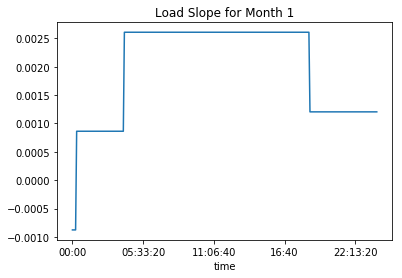

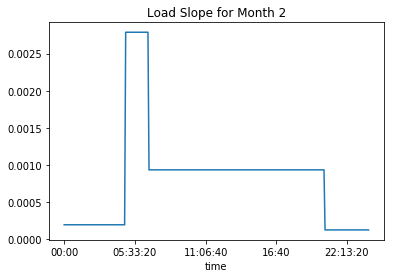

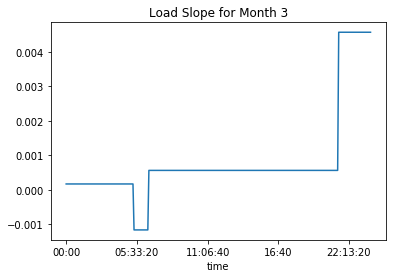

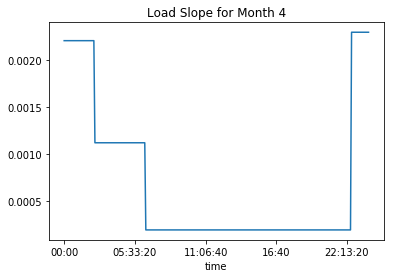

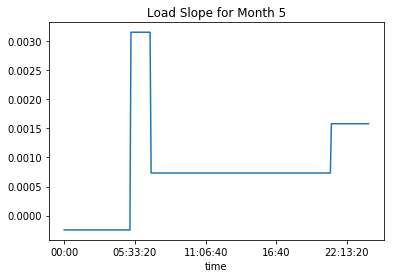

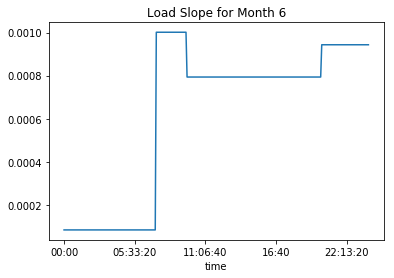

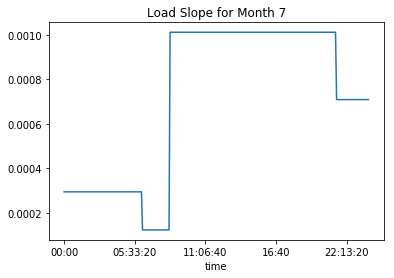

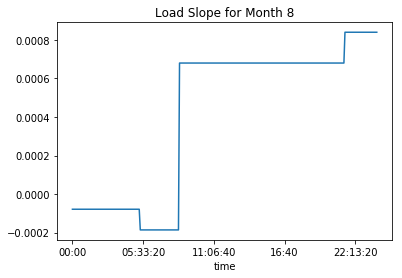

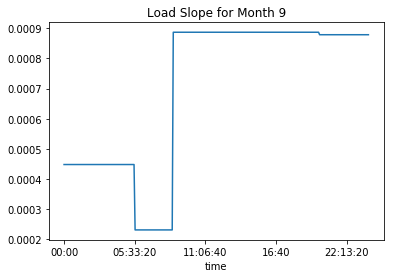

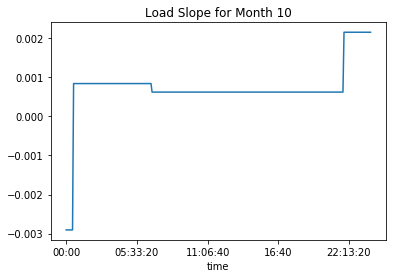

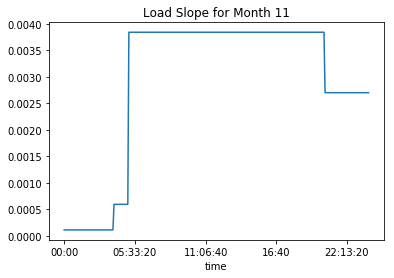

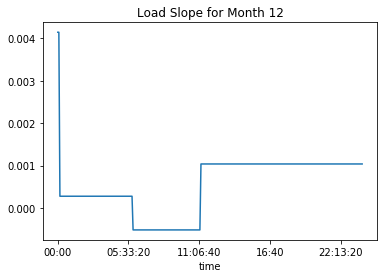

100.0%
MAPE ± std
6 predictors: 7.400091673927073 ± 2.002642180622302
4 predictors: 16.608308025840547 ± 4.673192730023696
# of errors: 0


In [11]:
# Calculating avg slopes

np.seterr(divide='print',invalid='print')

n = 10
PE_8_list = []
PE_4_list = []
errors = 0

df = DART2018

slopes = {}

for i in range(n):
    for j in range(1,13):
        by_month = df[df['Month']==j]

        train, test = train_test_split(by_month, test_size=0.5)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Previous_RT_2']].mean()
        train_data['RT_std'] = train.groupby('Local Time')['LMP_RT'].std()
        train_data['DA_std'] = train.groupby('Local Time')['LMP_DA'].std()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Previous_RT_2']].mean()
        test_data['RT_std'] = test.groupby('Local Time')['LMP_RT'].std()
        test_data['DA_std'] = test.groupby('Local Time')['LMP_DA'].std() 
        test_data_copy = test_data.copy()
        
        test_data_copy['fitted RT (8)'] = np.zeros(test_data_copy.index.shape[0])
        test_data_copy['fitted RT (4)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters_2(train_data, 2, False)
        load_slopes = []
        for cluster in branch_dfs:
            try:
                result8 = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Previous_RT_2""", data=cluster).fit()
                result4 = smf.ols(formula="""LMP_RT ~ LMP_DA + Load + Wind + Previous_RT_2""", data=cluster).fit()
                for var in result8.params.index:
                    if var not in slopes.keys():
                        slopes[var] = []
                        slopes[var].append(result8.params.loc[var])
                    else:
                        slopes[var].append(result8.params.loc[var])
                for hour in cluster.index:
                    load_slopes.append(result8.params.loc['Load'])
                    test_data_copy['fitted RT (8)'].loc[hour] = (
                                                test_data_copy['Previous_RT_2'].loc[hour]*result8.params[6] +  
                                                test_data_copy['Wind'].loc[hour]*result8.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result8.params[4] + 
                                                test_data_copy['DA_std'].loc[hour]*result8.params[3] + 
                                                test_data_copy['RT_std'].loc[hour]*result8.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result8.params[1] + 
                                                result8.params[0])
                    test_data_copy['fitted RT (4)'].loc[hour] = (
                                                test_data_copy['Previous_RT_2'].loc[hour]*result4.params[4] +  
                                                test_data_copy['Wind'].loc[hour]*result4.params[3] + 
                                                test_data_copy['Load'].loc[hour]*result4.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result4.params[1] + 
                                                result4.params[0])
            except:
                errors += 1
                print('\nerror occurred at i={} month={}'.format(i,j))
                continue
        PE_8_list.append(pe(test_data_copy['fitted RT (8)'], test_data_copy['LMP_RT']).mean())
        PE_4_list.append(pe(test_data_copy['fitted RT (4)'], test_data_copy['LMP_RT']).mean())
        if i == 0:
            plt.title('Load Slope for Month {}'.format(j))
            plt.plot(test_data.index, np.array(load_slopes))
            plt.show()
    print(f'\r{100*(i+1)/n}%',end='')

PE_8_array = np.array(PE_8_list)
PE_4_array = np.array(PE_4_list)

print('\nMAPE \u00B1 std')
print('6 predictors: {} \u00B1 {}'.format(PE_8_array.mean(), PE_8_array.std()))
print('4 predictors: {} \u00B1 {}'.format(PE_4_array.mean(), PE_4_array.std()))
print('# of errors: {}'.format(errors))

In [43]:
means_std_dict(slopes)

{'Intercept': [-2.967397, 2.429615],
 'LMP_DA': [-0.073152, 0.033698],
 'RT_std': [0.126332, 0.012571],
 'DA_std': [-0.127069, 0.028163],
 'Load': [0.000905, 0.000144],
 'Wind': [-0.000906, 0.000266],
 'Previous_RT_2': [0.228136, 0.010878]}

In [12]:
jan = DART2018[DART2018['Month']==1]
x = jan['Load'].values.tolist()
y = jan['LMP_RT'].values.tolist()
plt.plot(x,y,'ro')jan = DART2018[DART2018['Month']==1]
x = jan['Load'].values.tolist()
y = jan['LMP_RT'].values.tolist()
plt.plot(x,y,'ro')

SyntaxError: invalid syntax (<ipython-input-12-24c028267752>, line 4)

Text(0.5, 1.0, 'Month 9')

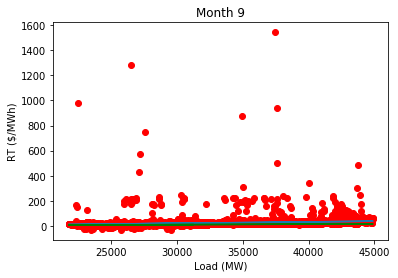

In [13]:
jan = DART2018[(DART2018['Month']==9)]
x = jan['Load']
y = jan['LMP_RT']
k = 0
x1 = []
y1 = []
for value in x:
    if np.isnan(value) == False:
        x1.append(x[k])
        y1.append(y[k])
    k += 1
x1 = np.array(x1)
y1 = np.array(y1)
m, b = np.polyfit(x1, y1, 1)
result4 = smf.ols(formula="""LMP_RT ~ LMP_DA + Load + Wind + Previous_RT_2""", data=jan).fit()
plt.plot(x1,y1,'ro')
plt.plot(x1,x1*m+b)
plt.plot(x1,x1*result4.params.loc['Load'],'green')
plt.ylabel('RT ($/MWh)')
plt.xlabel('Load (MW)')
plt.title('Month 9')

In [44]:
m

0.0029293927327733453

In [41]:
result = smf.ols(formula="""LMP_RT ~ Load""", data=DART2018).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LMP_RT   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2451.
Date:                Fri, 31 Jul 2020   Prob (F-statistic):               0.00
Time:                        12:51:09   Log-Likelihood:            -5.3478e+05
No. Observations:              104858   AIC:                         1.070e+06
Df Residuals:                  104856   BIC:                         1.070e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.6970      0.699    -13.869      0.000     -11.067      -8.327
Load           0.0011   2.22e-05     49.507      0.000       0.001       0.001
==============================================================================
Omnibus:                   225917.332   Durbin-Watson:                   0.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1292904342.091
Skew:                          19.349   Prob(JB):                         0.00
Kurtosis:                     545.608   Cond. No.                     1.80e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [52]:
result = smf.ols(formula="""LMP_RT ~ I(Load)**2""", data=DART2018).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LMP_RT   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2451.
Date:                Fri, 31 Jul 2020   Prob (F-statistic):               0.00
Time:                        13:02:53   Log-Likelihood:            -5.3478e+05
No. Observations:              104858   AIC:                         1.070e+06
Df Residuals:                  104856   BIC:                         1.070e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.6970      0.699    -13.869      0.000     -11.067      -8.327
I(Load)        0.0011   2.22e-05     49.507      0.000       0.001       0.001
==============================================================================
Omnibus:                   225917.332   Durbin-Watson:                   0.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1292904342.091
Skew:                          19.349   Prob(JB):                         0.00
Kurtosis:                     545.608   Cond. No.                     1.80e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

0.020736831449899042

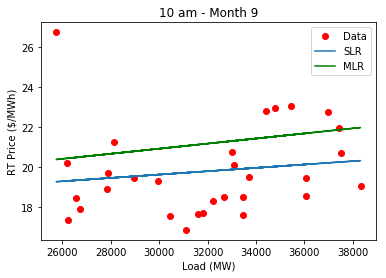

In [14]:
month = DART2018[DART2018['Month']==9]
month_t = month[month['Local Time']==dt.time(10,0)]
x1 = month_t['Load']
y1 = month_t['LMP_RT']
m, b, r, p, std = stats.linregress(x1, y1)
plt.plot(x1,y1,'ro',label='Data')
plt.plot(x1,x1*m+b,label='SLR')
result4 = smf.ols(formula="""LMP_RT ~ LMP_DA + Load + Wind + Previous_RT_2""", data=month_t).fit()
plt.plot(x1,x1*result4.params.loc['Load']+b,'green',label='MLR')
plt.title('10 am - Month 9')
plt.xlabel('Load (MW)')
plt.ylabel('RT Price ($/MWh)')
plt.legend()
r**2

In [51]:
jan1 = jan[jan['Local Time']==dt.time(12,0)]
x1 = jan1['Load']
y1 = jan1['LMP_RT']
result = smf.ols(formula="""LMP_RT ~ I(Load)**2""", data=jan1).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LMP_RT   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     8.768
Date:                Fri, 31 Jul 2020   Prob (F-statistic):            0.00606
Time:                        13:02:10   Log-Likelihood:                -119.23
No. Observations:                  31   AIC:                             242.5
Df Residuals:                      29   BIC:                             245.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -36.7397     20.545     -1.788      0.084     -78.759       5.280
I(Load)        0.0019      0.001      2.961      0.006       0.001       0.003
==============================================================================
Omnibus:                        2.488   Durbin-Watson:                   1.065
Prob(Omnibus):                  0.288   Jarque-Bera (JB):                1.309
Skew:                           0.142   Prob(JB):                        0.520
Kurtosis:                       3.966   Cond. No.                     3.20e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

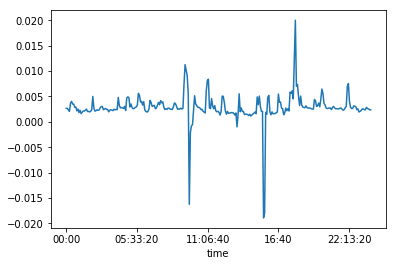

In [59]:
hours = jan.groupby('Local Time').count().index
slopes = []
for time in hours:
    result = smf.ols(formula="""LMP_RT ~ Load""", data=jan[jan['Local Time']==time]).fit()
    slopes.append(result.params.loc['Load'])
plt.plot(hours,slopes)

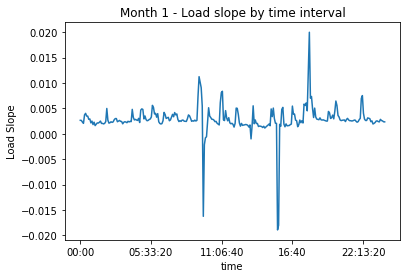

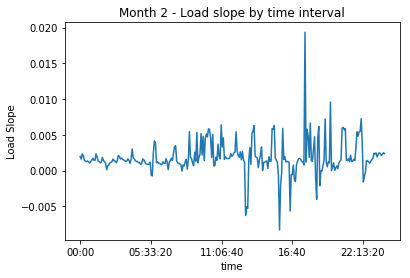

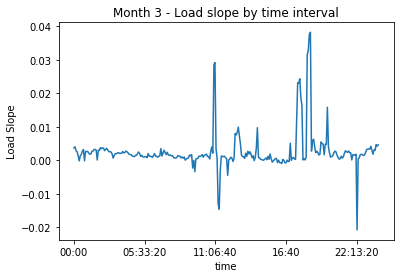

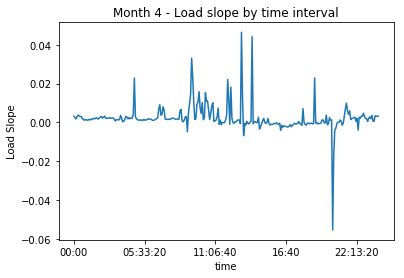

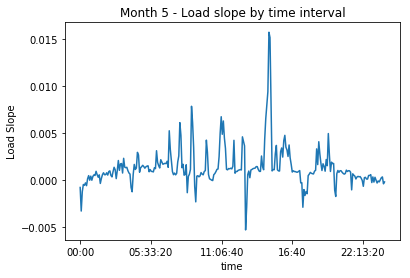

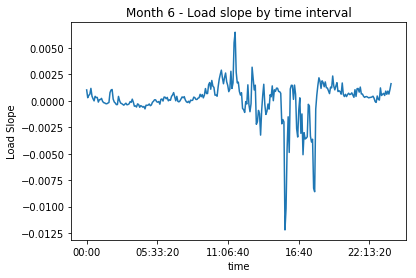

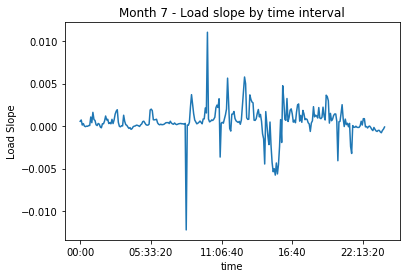

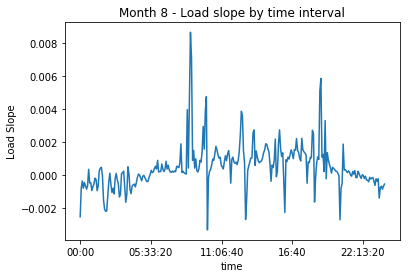

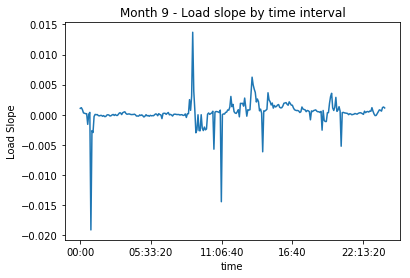

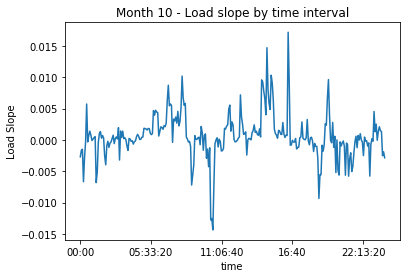

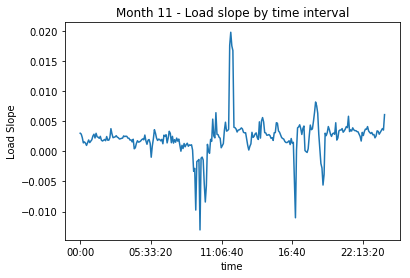

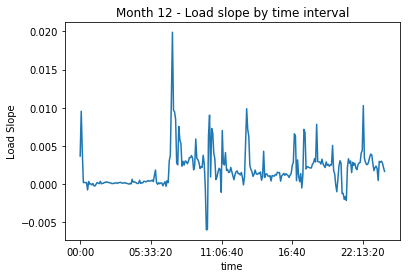

In [67]:
intervals = DART2018.groupby('Local Time').count().index
for month in range (1,13):
    month_df = DART2018[DART2018['Month']==month]
    slopes = []
    for t in intervals:
        result = smf.ols(formula = "LMP_RT ~ Load", data = month_df[month_df['Local Time']==t]).fit()
        slopes.append(result.params.loc['Load'])
    fig, ax = plt.subplots()
    ax.plot(hours, slopes)
    #ax2.plot(hours, month_df.groupby('Local Time')[['LMP_RT']].mean()['LMP_RT'], 'red')
    plt.ylabel('Load Slope')
    plt.title('Month {} - Load slope by time interval'.format(month))
    plt.show()
    

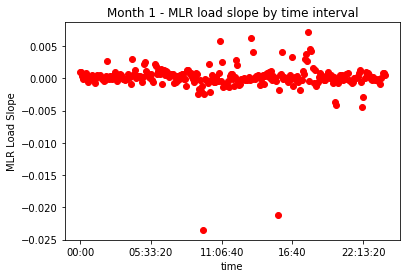

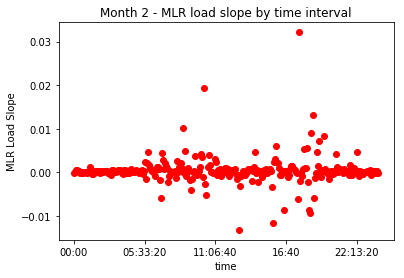

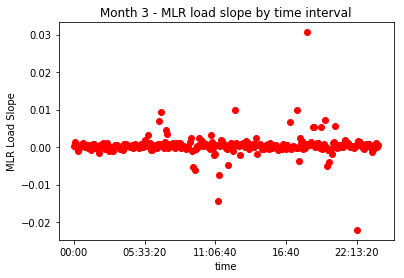

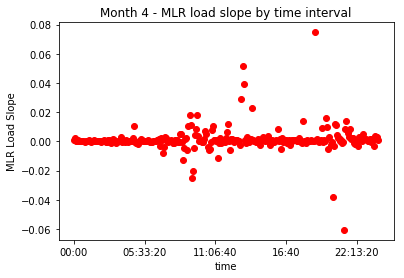

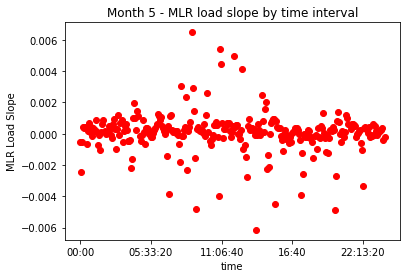

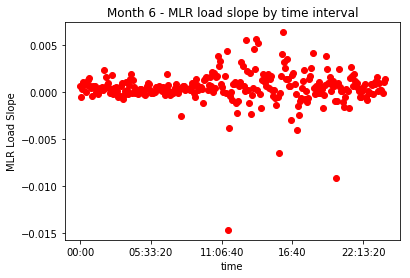

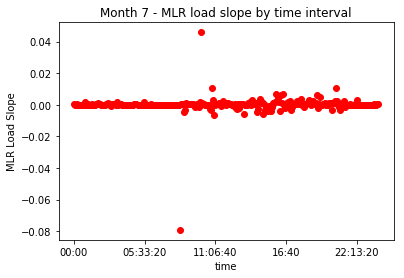

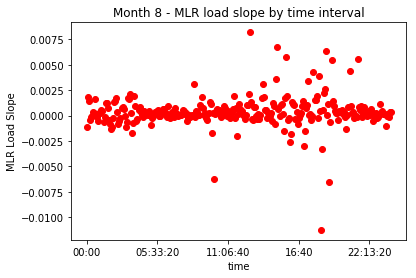

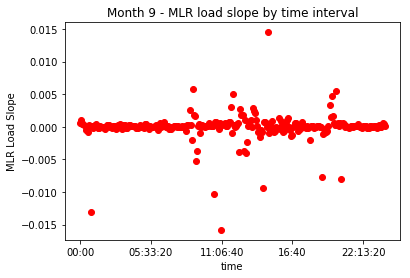

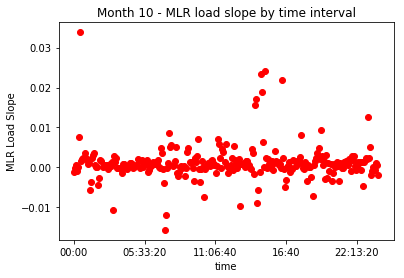

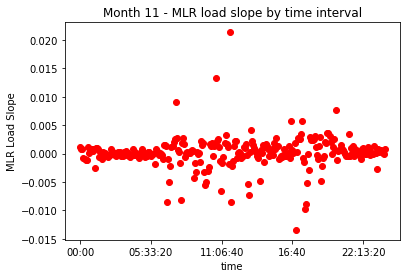

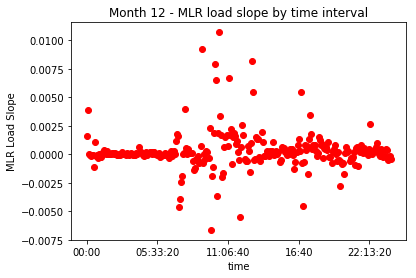

In [89]:
intervals = DART2018.groupby('Local Time').count().index
for month in range (1,13):
    month_df = DART2018[DART2018['Month']==month]
    slopes = []
    for t in intervals:
        result = smf.ols(formula = "LMP_RT ~ LMP_DA + Load + Wind + Previous_RT_2", data = month_df[month_df['Local Time']==t]).fit()
        slopes.append(result.params.loc['Load'])
    fig, ax = plt.subplots()
    ax.plot(hours, slopes, 'ro')
    #ax2.plot(hours, month_df.groupby('Local Time')[['LMP_RT']].mean()['LMP_RT'], 'red')
    plt.ylabel('MLR Load Slope')
    plt.title('Month {} - MLR load slope by time interval'.format(month))
    plt.show()
    

In [18]:
# Calculating avg slopes

np.seterr(divide='print',invalid='print')

n = 10
PE_8_list = []
PE_4_list = []
errors = 0

df = DART2018

slopes = {}

for i in range(n):
    for j in range(1,13):
        by_month = df[df['Month']==j]

        train, test = train_test_split(by_month, test_size=0.33)

        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Previous_RT_2', 'Load_Diff']].mean()
        train_data['RT_std'] = train.groupby('Local Time')['LMP_RT'].std()
        train_data['DA_std'] = train.groupby('Local Time')['LMP_DA'].std()        
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Previous_RT_2', 'Load_Diff']].mean()
        test_data['RT_std'] = test.groupby('Local Time')['LMP_RT'].std()
        test_data['DA_std'] = test.groupby('Local Time')['LMP_DA'].std() 
        test_data_copy = test_data.copy()
        
        test_data_copy['fitted RT (6)'] = np.zeros(test_data_copy.index.shape[0])
        test_data_copy['fitted RT (5)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters_2(train_data, 2, False)
        load_slopes = []
        for cluster in branch_dfs:
            try:
                result8 = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Previous_RT_2""", data=cluster).fit()
                result4 = smf.ols(formula="""LMP_RT ~ LMP_DA + Load + Wind + Previous_RT_2 + Load_Diff""", data=cluster).fit()
                for var in result8.params.index:
                    if var not in slopes.keys():
                        slopes[var] = []
                        slopes[var].append(result8.params.loc[var])
                    else:
                        slopes[var].append(result8.params.loc[var])
                for hour in cluster.index:
                    load_slopes.append(result8.params.loc['Load'])
                    test_data_copy['fitted RT (6)'].loc[hour] = (
                                                test_data_copy['Previous_RT_2'].loc[hour]*result8.params[6] +  
                                                test_data_copy['Wind'].loc[hour]*result8.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result8.params[4] + 
                                                test_data_copy['DA_std'].loc[hour]*result8.params[3] + 
                                                test_data_copy['RT_std'].loc[hour]*result8.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result8.params[1] + 
                                                result8.params[0])
                    test_data_copy['fitted RT (5)'].loc[hour] = (
                                                test_data_copy['Load_Diff'].loc[hour]*result4.params[5] +  
                                                test_data_copy['Previous_RT_2'].loc[hour]*result4.params[4] +  
                                                test_data_copy['Wind'].loc[hour]*result4.params[3] + 
                                                test_data_copy['Load'].loc[hour]*result4.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result4.params[1] + 
                                                result4.params[0])
            except:
                errors += 1
                print('\nerror occurred at i={} month={}'.format(i,j))
                continue
        PE_8_list.append(pe(test_data_copy['fitted RT (6)'], test_data_copy['LMP_RT']).mean())
        PE_4_list.append(pe(test_data_copy['fitted RT (5)'], test_data_copy['LMP_RT']).mean())
        
    print(f'\r{100*(i+1)/n}%',end='')

PE_8_array = np.array(PE_8_list)
PE_4_array = np.array(PE_4_list)

print('\nMAPE \u00B1 std')
print('6 predictors: {} \u00B1 {}'.format(PE_8_array.mean(), PE_8_array.std()))
print('5 predictors: {} \u00B1 {}'.format(PE_4_array.mean(), PE_4_array.std()))
print('# of errors: {}'.format(errors))

100.0%
MAPE ± std
6 predictors: 10.13800919973055 ± 4.870443786024444
5 predictors: 18.991650954773423 ± 5.795726997701442
# of errors: 0


Using STDs as predictors: 7.7 +- 2.4 (TS 50%), 10.1 +- 4.9 (TS 33%)

Not using: 16.6 +- 4.7 (TS 50%), 19.0 +- 5.8 (TS 33%)

In [25]:
DART2018.columns

Index(['DA Load', 'GMT MKT Interval', 'Coal_Mkt', 'Coal_Self',
       ' Diesel Fuel Oil Market', ' Diesel Fuel Oil Self', ' Hydro Market',
       ' Hydro Self', ' Natural Gas Market', ' Gas Self', ' Nuclear Market',
       ' Nuclear Self', ' Solar Market', ' Solar Self',
       ' Waste Disposal Services Market', ' Waste Disposal Services Self',
       ' Wind Market', 'Wind', ' Waste Heat Market', ' Waste Heat Self',
       ' Other Market', ' Other Self', 'Load', 'Local Date_gen',
       'Local Time_gen', 'Interval_DA', 'LMP_DA', 'Interval_RT', 'LMP_RT',
       'Local Date', 'Local Time', 'Hour', 'Weekday', 'Month', 'Day',
       'Minute of Day', 'Previous_RT_2', 'Load_Diff'],
      dtype='object')

In [37]:
test[test['Day']==test['Day'][0]]['Local Time'].shape

(103,)

In [43]:
l = random.sample(range(1,32),15)
l

[21, 11, 3, 27, 31, 25, 26, 13, 9, 5, 30, 20, 14, 24, 7]

In [44]:
by_month.loc[by_month['Day'].isin(l)]

DA Load      GMT MKT Interval  Coal_Mkt  Coal_Self  \
Interval                                                                  
12/03/2018 00:00:00  28167.0  2018-12-03T06:00:00Z    2287.9    12778.1   
12/03/2018 00:05:00  28167.0  2018-12-03T06:05:00Z    2289.1    12781.5   
12/03/2018 00:10:00  28167.0  2018-12-03T06:10:00Z    2288.4    12859.1   
12/03/2018 00:15:00  28167.0  2018-12-03T06:15:00Z    2278.7    12768.0   
12/03/2018 00:20:00  28167.0  2018-12-03T06:20:00Z    2274.0    12734.4   
12/03/2018 00:25:00  28167.0  2018-12-03T06:25:00Z    2261.9    12685.0   
12/03/2018 00:30:00  28167.0  2018-12-03T06:30:00Z    2254.2    12755.7   
12/03/2018 00:35:00  28167.0  2018-12-03T06:35:00Z    2211.4    12752.3   
12/03/2018 00:40:00  28167.0  2018-12-03T06:40:00Z    2198.6    12753.1   
12/03/2018 00:45:00  28167.0  2018-12-03T06:45:00Z    2186.0    12800.8   
12/03/2018 00:50:00  28167.0  2018-12-03T06:50:00Z    2174.1    12846.2   
12/03/2018 00:55:00  28167.0  2018-12-03T06:55:00Z    2156.9    12860.0   
12/03/2018 01:00:00  27997.8  2018-12-03T07:00:00Z    2118.9    12853.2   
12/03/2018 01:05:00  27997.8  2018-12-03T07:05:00Z    2126.0    12913.7   
12/03/2018 01:10:00  27997.8  2018-12-03T07:10:00Z    2121.3    12894.3   
12/03/2018 01:15:00  27997.8  2018-12-03T07:15:00Z    2120.4    12902.7   
12/03/2018 01:20:00  27997.8  2018-12-03T07:20:00Z    2122.0    12880.7   
12/03/2018 01:25:00  27997.8  2018-12-03T07:25:00Z    2121.8    12921.5   
12/03/2018 01:30:00  27997.8  2018-12-03T07:30:00Z    2122.3    12933.1   
12/03/2018 01:35:00  27997.8  2018-12-03T07:35:00Z    2121.9    12940.6   
12/03/2018 01:40:00  27997.8  2018-12-03T07:40:00Z    2121.2    12876.2   
12/03/2018 01:45:00  27997.8  2018-12-03T07:45:00Z    2121.7    12863.5   
12/03/2018 01:50:00  27997.8  2018-12-03T07:50:00Z    2121.8    12845.5   
12/03/2018 01:55:00  27997.8  2018-12-03T07:55:00Z    2121.7    12768.1   
12/03/2018 02:00:00  27771.9  2018-12-03T08:00:00Z    2115.9    12713.9   
12/03/2018 02:05:00  27771.9  2018-12-03T08:05:00Z    2120.0    12720.1   
12/03/2018 02:10:00  27771.9  2018-12-03T08:10:00Z    2121.4    12706.2   
12/03/2018 02:15:00  27771.9  2018-12-03T08:15:00Z    2121.3    12745.8   
12/03/2018 02:20:00  27771.9  2018-12-03T08:20:00Z    2121.3    12876.8   
12/03/2018 02:25:00  27771.9  2018-12-03T08:25:00Z    2121.4    12913.1   
...                      ...                   ...       ...        ...   
12/31/2018 21:30:00  33261.5  2019-01-01T03:30:00Z     422.5     9437.3   
12/31/2018 21:35:00  33261.5  2019-01-01T03:35:00Z     415.7     9459.2   
12/31/2018 21:40:00  33261.5  2019-01-01T03:40:00Z     422.9     9461.6   
12/31/2018 21:45:00  33261.5  2019-01-01T03:45:00Z     417.5     9410.9   
12/31/2018 21:50:00  33261.5  2019-01-01T03:50:00Z     415.2     9469.2   
12/31/2018 21:55:00  33261.5  2019-01-01T03:55:00Z     408.4     9380.8   
12/31/2018 22:00:00  32996.2  2019-01-01T04:00:00Z     402.3     9412.2   
12/31/2018 22:05:00  32996.2  2019-01-01T04:05:00Z     410.5     9559.4   
12/31/2018 22:10:00  32996.2  2019-01-01T04:10:00Z     417.2     9754.8   
12/31/2018 22:15:00  32996.2  2019-01-01T04:15:00Z     422.7     9859.4   
12/31/2018 22:20:00  32996.2  2019-01-01T04:20:00Z     418.1     9864.4   
12/31/2018 22:25:00  32996.2  2019-01-01T04:25:00Z     416.4     9839.1   
12/31/2018 22:30:00  32996.2  2019-01-01T04:30:00Z     424.9     9943.3   
12/31/2018 22:35:00  32996.2  2019-01-01T04:35:00Z     416.3     9898.2   
12/31/2018 22:40:00  32996.2  2019-01-01T04:40:00Z     423.0     9880.8   
12/31/2018 22:45:00  32996.2  2019-01-01T04:45:00Z     414.7     9839.0   
12/31/2018 22:50:00  32996.2  2019-01-01T04:50:00Z     412.4     9898.8   
12/31/2018 22:55:00  32996.2  2019-01-01T04:55:00Z     403.8     9958.1   
12/31/2018 23:00:00  31833.4  2019-01-01T05:00:00Z     414.6     9957.3   
12/31/2018 23:05:00  31833.4  2019-01-01T05:05:00Z     409.6     9999.2   
12/31/2018 23:10:00  31833.4  2019-01-01T05:10

In [47]:
by_month.loc[~by_month['Day'].isin(l)]

DA Load      GMT MKT Interval  Coal_Mkt  Coal_Self  \
Interval                                                                  
12/01/2018 00:00:00  27642.3  2018-12-01T06:00:00Z    1515.8     8603.7   
12/01/2018 00:05:00  27642.3  2018-12-01T06:05:00Z    1488.3     8496.6   
12/01/2018 00:10:00  27642.3  2018-12-01T06:10:00Z    1478.3     8444.0   
12/01/2018 00:15:00  27642.3  2018-12-01T06:15:00Z    1473.3     8362.4   
12/01/2018 00:20:00  27642.3  2018-12-01T06:20:00Z    1469.9     8249.3   
12/01/2018 00:25:00  27642.3  2018-12-01T06:25:00Z    1466.3     8102.3   
12/01/2018 00:30:00  27642.3  2018-12-01T06:30:00Z    1463.4     8064.5   
12/01/2018 00:35:00  27642.3  2018-12-01T06:35:00Z    1524.9     8173.7   
12/01/2018 00:40:00  27642.3  2018-12-01T06:40:00Z    1474.7     8120.5   
12/01/2018 00:45:00  27642.3  2018-12-01T06:45:00Z    1452.4     8105.2   
12/01/2018 00:50:00  27642.3  2018-12-01T06:50:00Z    1435.1     8042.1   
12/01/2018 00:55:00  27642.3  2018-12-01T06:55:00Z    1447.3     8037.5   
12/01/2018 01:00:00  26769.9  2018-12-01T07:00:00Z    1442.5     8143.9   
12/01/2018 01:05:00  26769.9  2018-12-01T07:05:00Z    1433.3     8170.3   
12/01/2018 01:10:00  26769.9  2018-12-01T07:10:00Z    1437.4     8327.8   
12/01/2018 01:15:00  26769.9  2018-12-01T07:15:00Z    1442.7     8435.9   
12/01/2018 01:20:00  26769.9  2018-12-01T07:20:00Z    1421.4     8501.4   
12/01/2018 01:25:00  26769.9  2018-12-01T07:25:00Z    1428.1     8290.7   
12/01/2018 01:30:00  26769.9  2018-12-01T07:30:00Z    1389.8     8418.2   
12/01/2018 01:35:00  26769.9  2018-12-01T07:35:00Z    1350.8     8358.2   
12/01/2018 01:40:00  26769.9  2018-12-01T07:40:00Z    1391.3     8258.1   
12/01/2018 01:45:00  26769.9  2018-12-01T07:45:00Z    1337.4     8223.4   
12/01/2018 01:50:00  26769.9  2018-12-01T07:50:00Z    1373.3     8110.9   
12/01/2018 01:55:00  26769.9  2018-12-01T07:55:00Z    1371.4     7975.3   
12/01/2018 02:00:00  26445.1  2018-12-01T08:00:00Z    1367.4     7804.1   
12/01/2018 02:05:00  26445.1  2018-12-01T08:05:00Z    1363.5     7701.4   
12/01/2018 02:10:00  26445.1  2018-12-01T08:10:00Z    1360.9     7646.7   
12/01/2018 02:15:00  26445.1  2018-12-01T08:15:00Z    1354.5     7620.8   
12/01/2018 02:20:00  26445.1  2018-12-01T08:20:00Z    1345.8     7663.9   
12/01/2018 02:25:00  26445.1  2018-12-01T08:25:00Z    1361.5     7747.2   
...                      ...                   ...       ...        ...   
12/29/2018 21:30:00  34007.8  2018-12-30T03:30:00Z    1790.4    12525.0   
12/29/2018 21:35:00  34007.8  2018-12-30T03:35:00Z    1769.3    12537.2   
12/29/2018 21:40:00  34007.8  2018-12-30T03:40:00Z    1754.4    12532.3   
12/29/2018 21:45:00  34007.8  2018-12-30T03:45:00Z    1770.1    12358.8   
12/29/2018 21:50:00  34007.8  2018-12-30T03:50:00Z    1789.0    12327.3   
12/29/2018 21:55:00  34007.8  2018-12-30T03:55:00Z    1776.2    12229.0   
12/29/2018 22:00:00  34049.6  2018-12-30T04:00:00Z    1526.2    12547.2   
12/29/2018 22:05:00  34049.6  2018-12-30T04:05:00Z    1544.7    12593.4   
12/29/2018 22:10:00  34049.6  2018-12-30T04:10:00Z    1542.0    12716.3   
12/29/2018 22:15:00  34049.6  2018-12-30T04:15:00Z    1543.2    12720.3   
12/29/2018 22:20:00  34049.6  2018-12-30T04:20:00Z    1533.9    12691.6   
12/29/2018 22:25:00  34049.6  2018-12-30T04:25:00Z    1525.6    12517.3   
12/29/2018 22:30:00  34049.6  2018-12-30T04:30:00Z    1514.3    12454.8   
12/29/2018 22:35:00  34049.6  2018-12-30T04:35:00Z    1490.7    12331.5   
12/29/2018 22:40:00  34049.6  2018-12-30T04:40:00Z    1485.7    12230.9   
12/29/2018 22:45:00  34049.6  2018-12-30T04:45:00Z    1487.7    12025.4   
12/29/2018 22:50:00  34049.6  2018-12-30T04:50:00Z    1470.5    11961.9   
12/29/2018 22:55:00  34049.6  2018-12-30T04:55:00Z    1474.6    11846.1   
12/29/2018 23:00:00  32396.3  2018-12-30T05:00:00Z    1438.6    11615.1   
12/29/2018 23:05:00  32396.3  2018-12-30T05:05:00Z    1455.2    11469.6   
12/29/2018 23:10:00  32396.3  2018-12-30T05:10

In [49]:
# Different train-test splitting method

df = DART2018

PE_list = []

for m in range (1,13):
    by_month = df[df['Month']==j]

    last_day = by_month.sort_values('Day')['Day'][-1]
    train_days = random.sample(range(1,last_day+1), 15)
    
    train = by_month.loc[by_month['Day'].isin(train_days)]
    train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Previous_RT_2', 'Load_Diff']].mean()  
    test = by_month.loc[~by_month['Day'].isin(train_days)]
    test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Previous_RT_2', 'Load_Diff']].mean()
    test_data_copy = test_data.copy()
    test_data_copy['fitted RT (5)'] = np.zeros(test_data.shape[0])
    
    branch_dfs = sklearn_clusters_2(train_data, 2, False)
    for cluster in branch_dfs:
        result4 = smf.ols(formula="""LMP_RT ~ LMP_DA + Load + Wind + Previous_RT_2 + Load_Diff""", data=cluster).fit()
        for hour in cluster.index:
            test_data_copy['fitted RT (5)'].loc[hour] = (
                                        test_data_copy['Load_Diff'].loc[hour]*result4.params[5] +  
                                        test_data_copy['Previous_RT_2'].loc[hour]*result4.params[4] +  
                                        test_data_copy['Wind'].loc[hour]*result4.params[3] + 
                                        test_data_copy['Load'].loc[hour]*result4.params[2] + 
                                        test_data_copy['LMP_DA'].loc[hour]*result4.params[1] + 
                                        result4.params[0])

    PE_list.append(pe(test_data_copy['fitted RT (5)'], test_data_copy['LMP_RT']).mean())
        
PE_array = np.array(PE_list)

print('\nMAPE \u00B1 std')
print('5 predictors: {} \u00B1 {}'.format(PE_array.mean(), PE_array.std()))


MAPE ± std
5 predictors: 32.236689191621586 ± 17.776479883071065


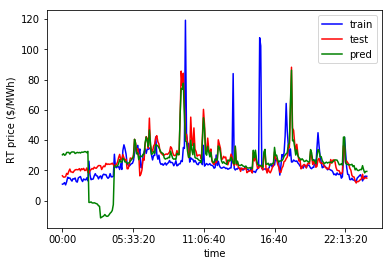

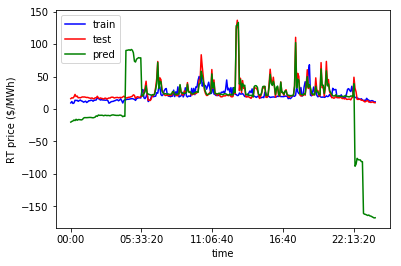

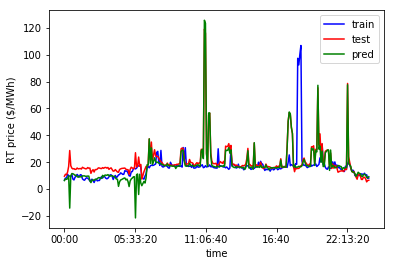

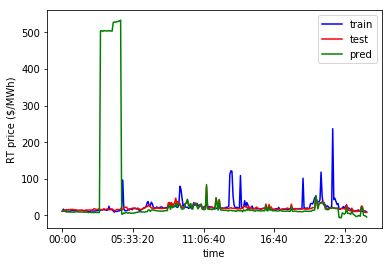

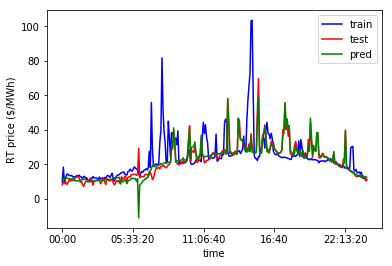

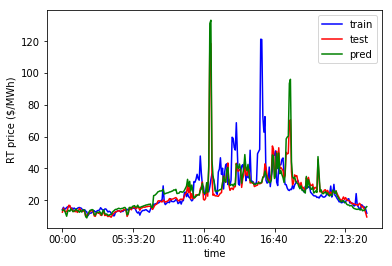

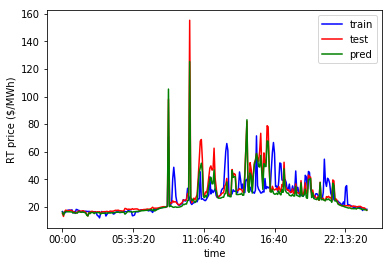

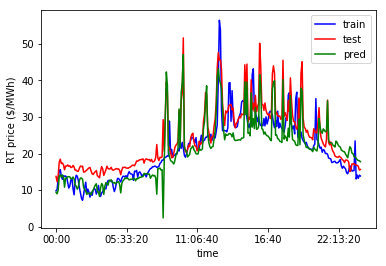

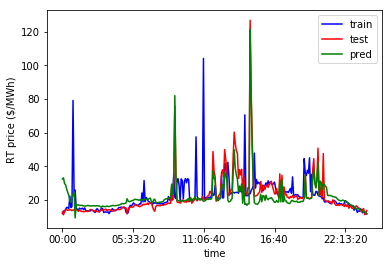

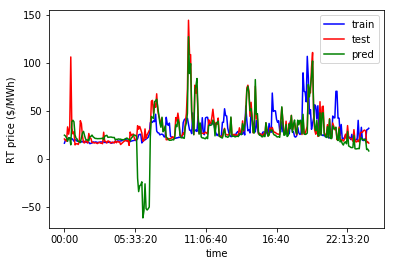

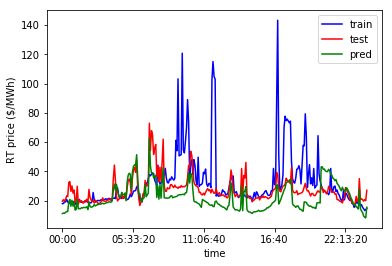

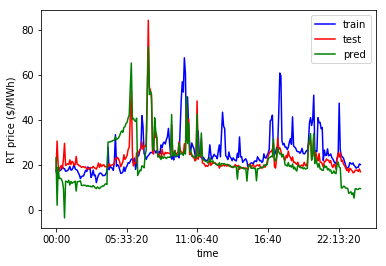

10.0%

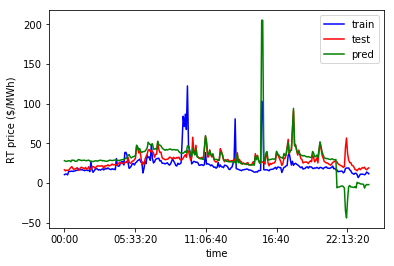

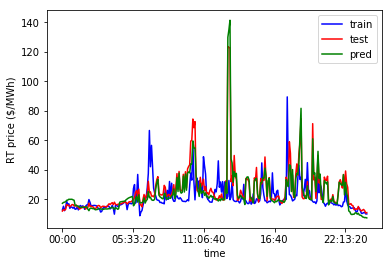

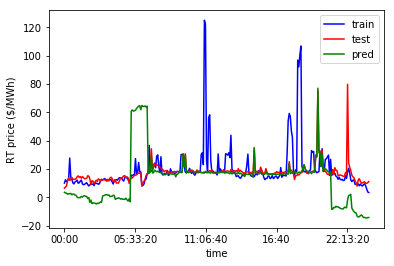

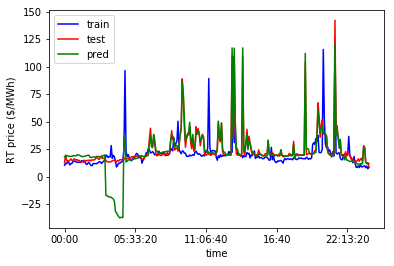

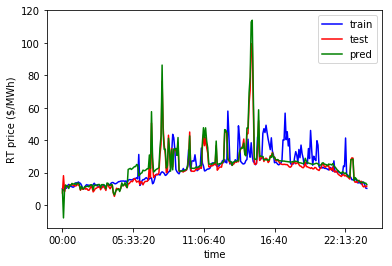

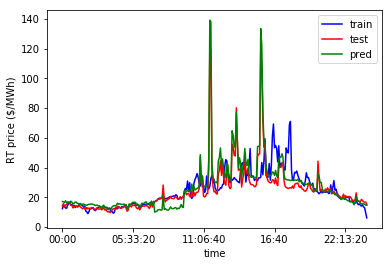

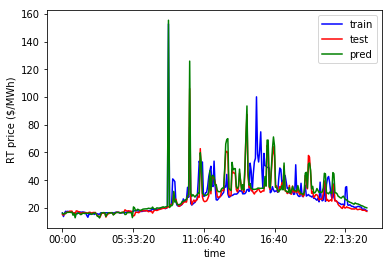

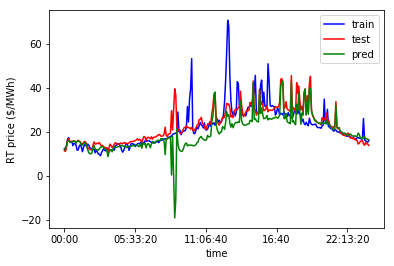

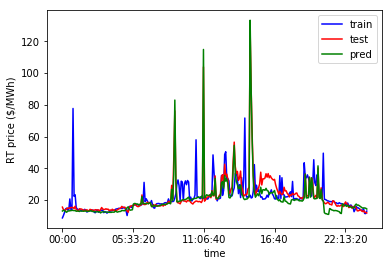

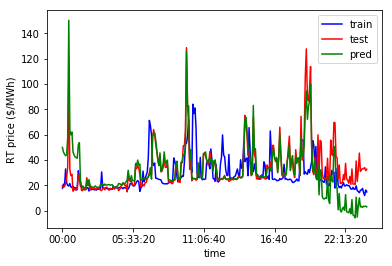

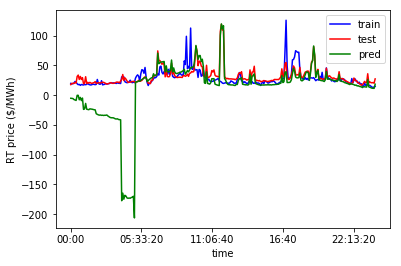

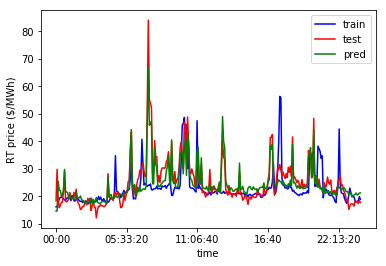

20.0%

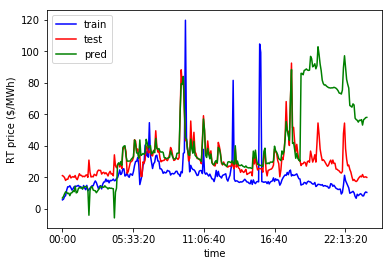

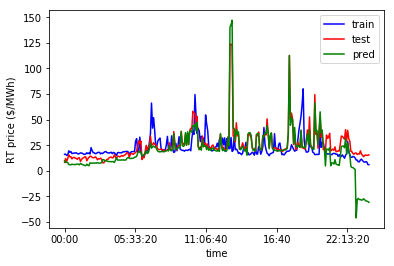

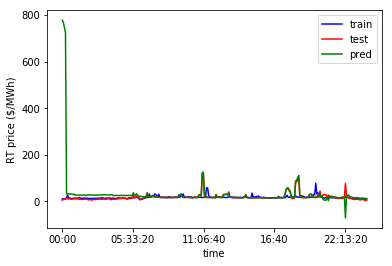

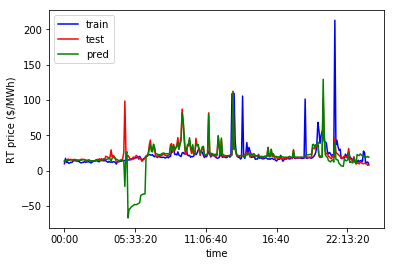

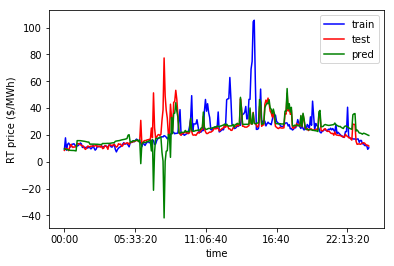

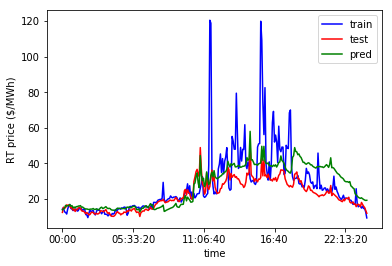

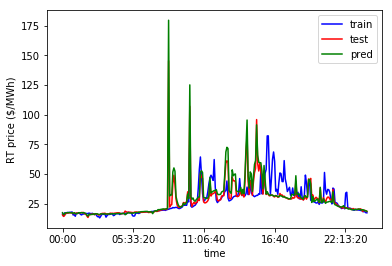

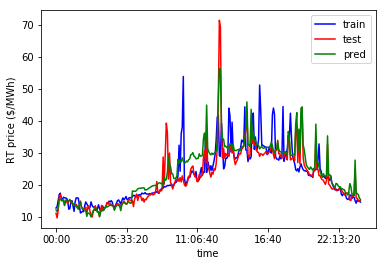

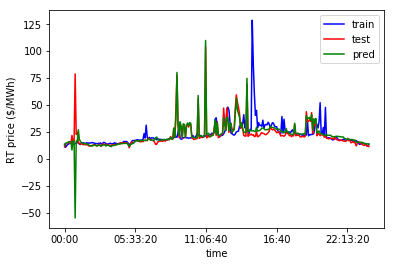

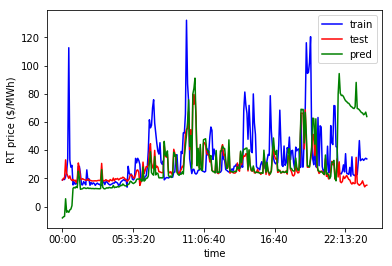

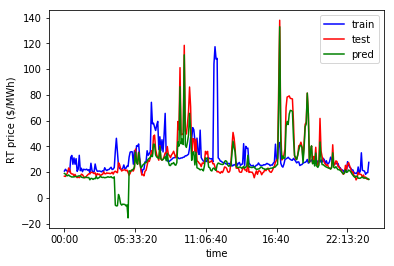

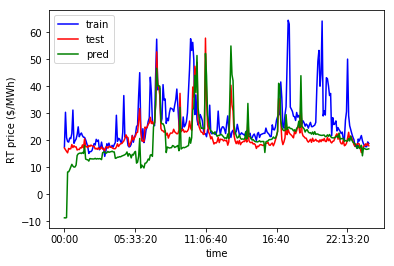

30.0%

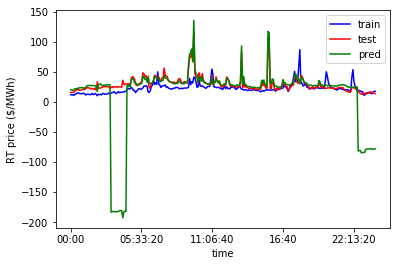

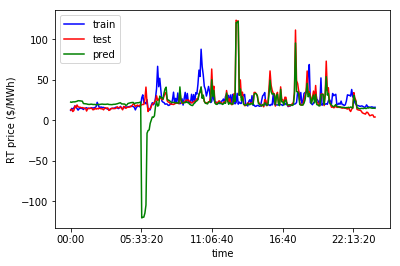

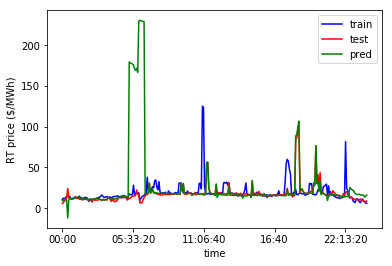

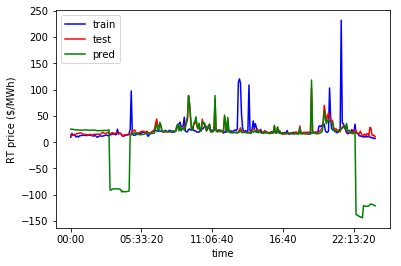

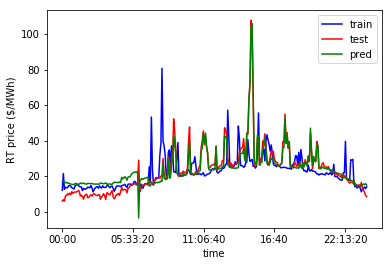

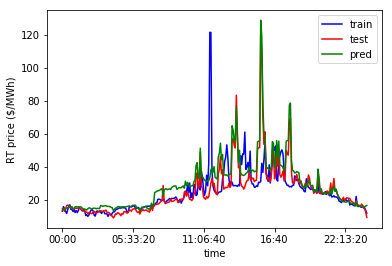

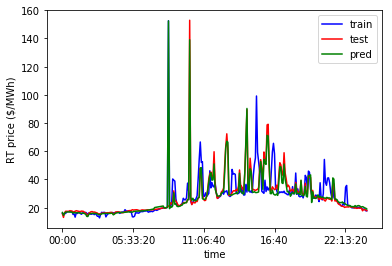

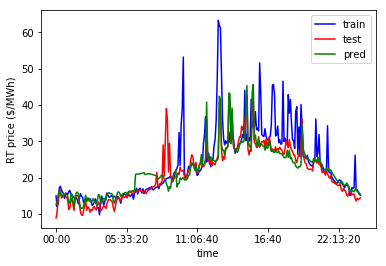

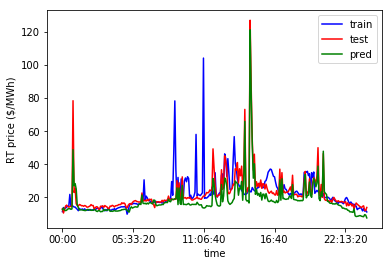

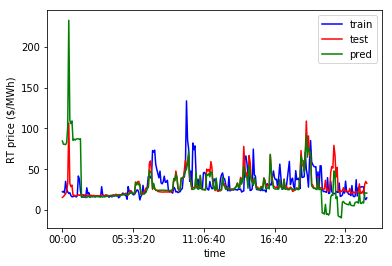

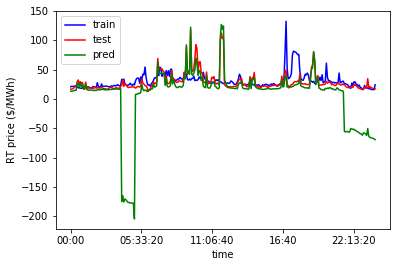

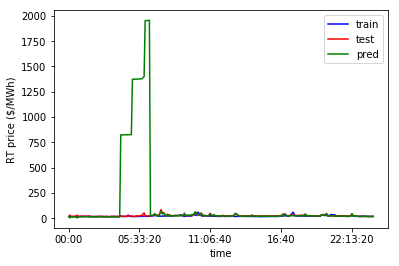

40.0%

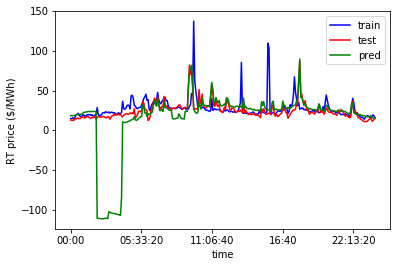

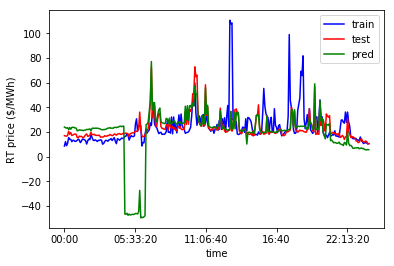

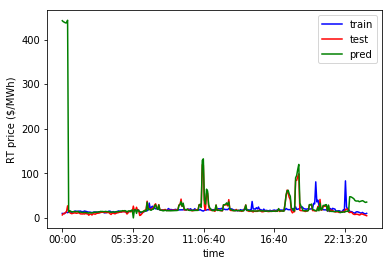

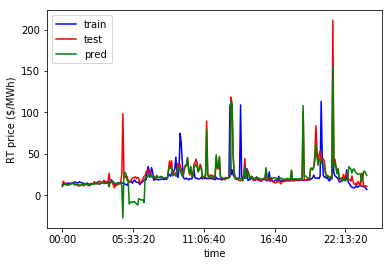

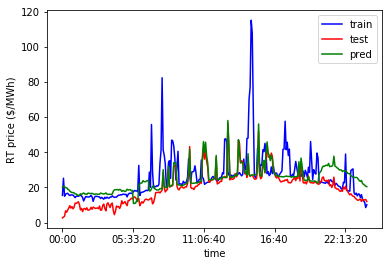

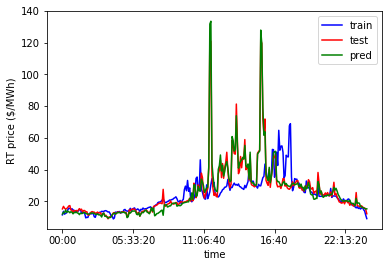

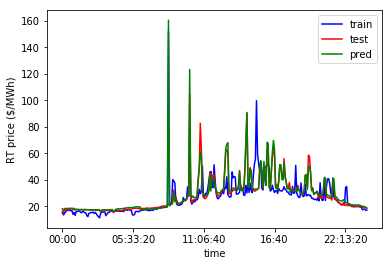

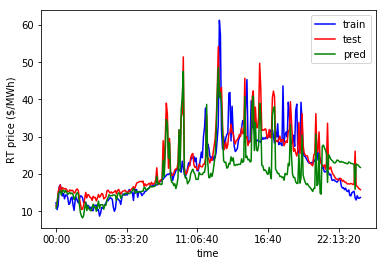

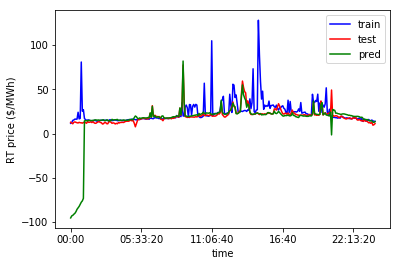

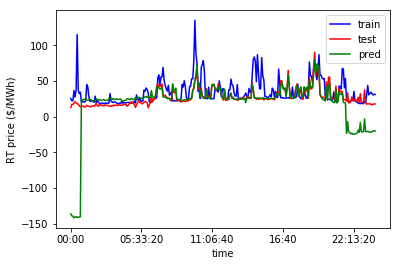

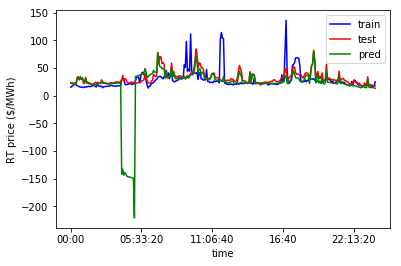

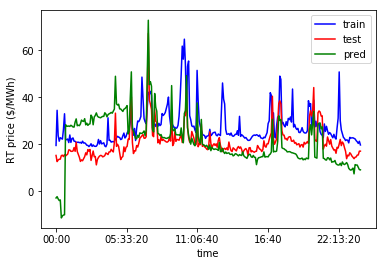

50.0%

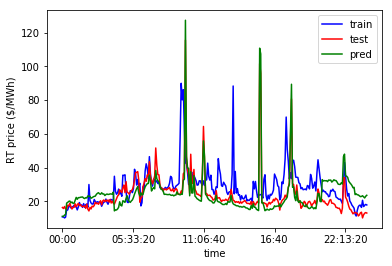

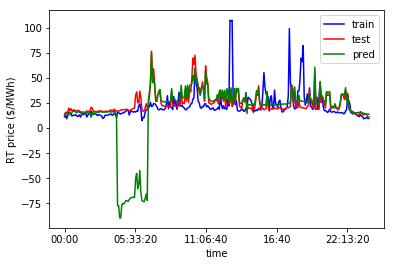

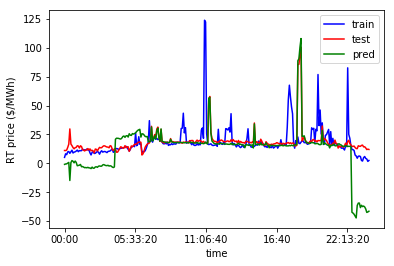

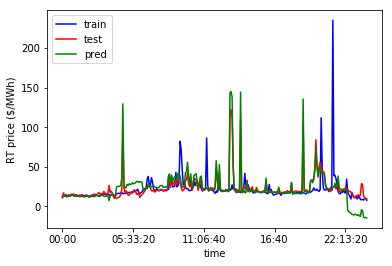

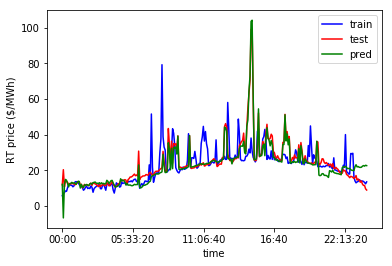

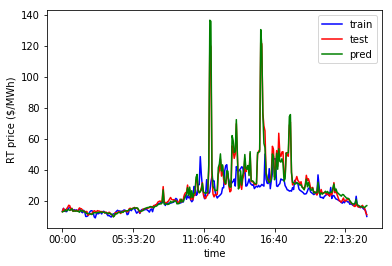

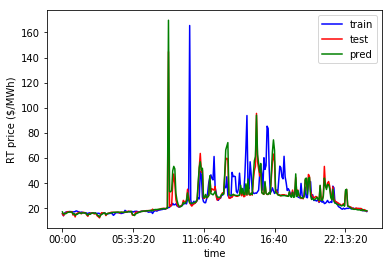

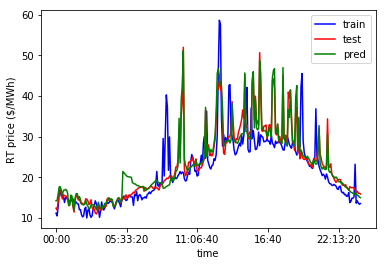

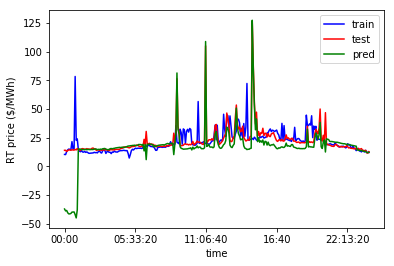

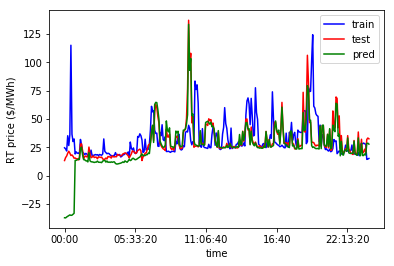

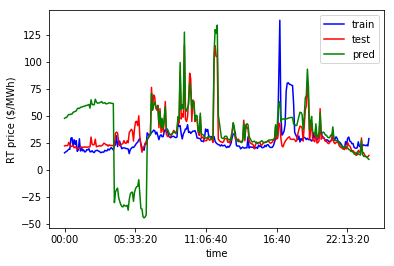

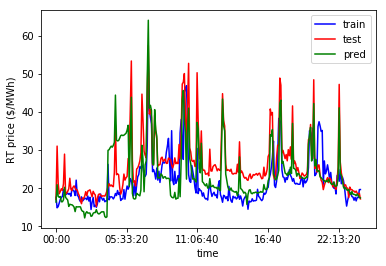

60.0%

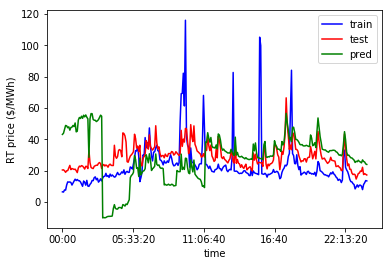

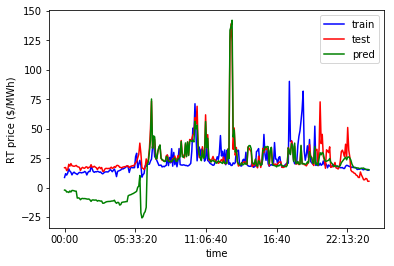

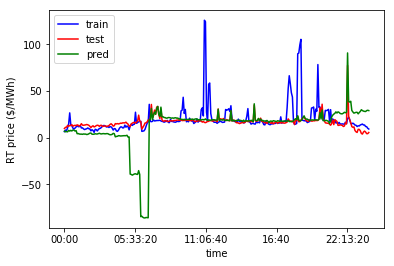

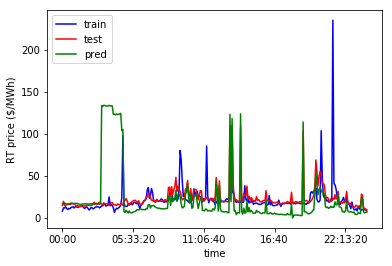

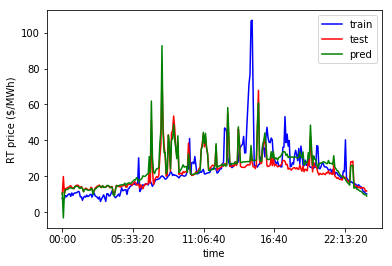

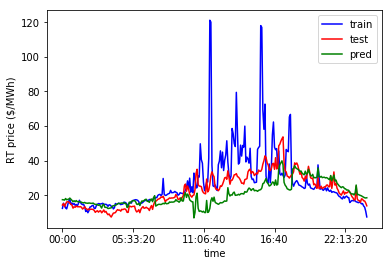

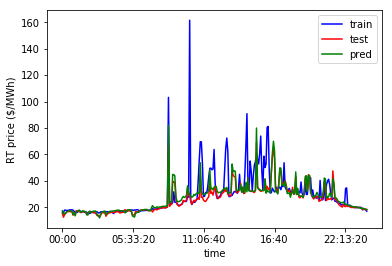

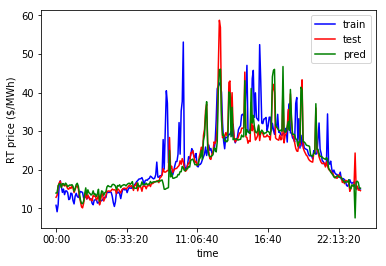

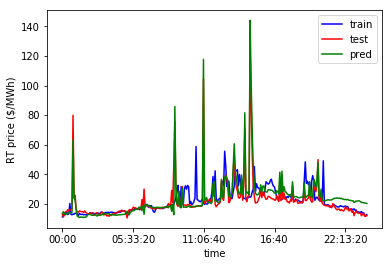

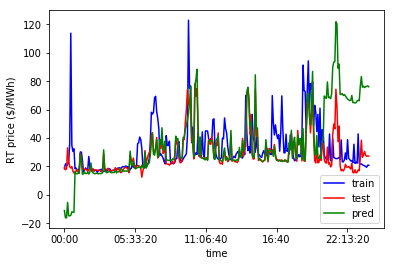

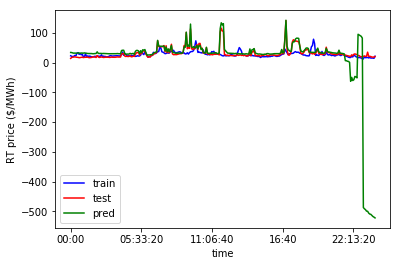

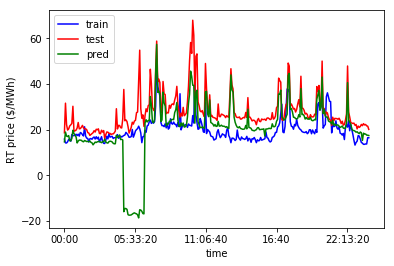

70.0%

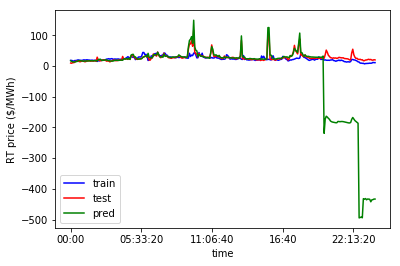

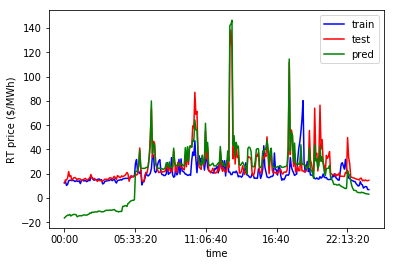

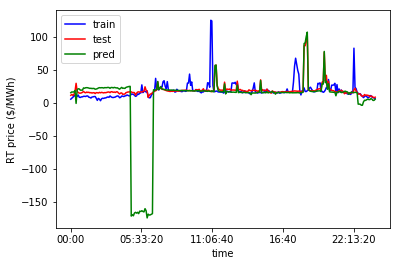

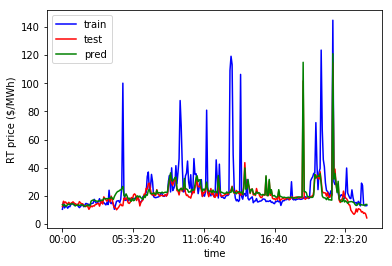

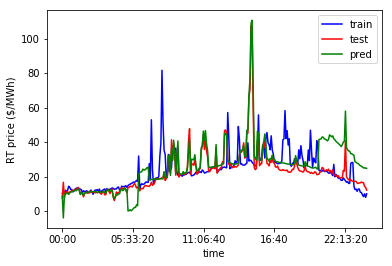

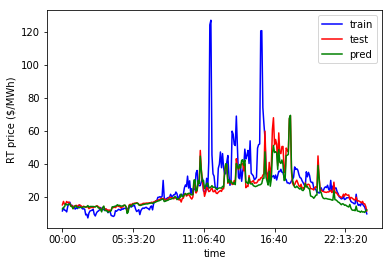

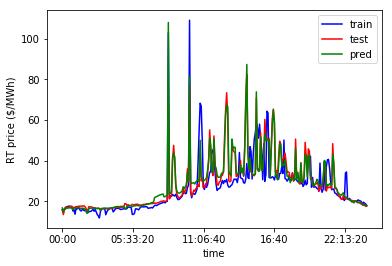

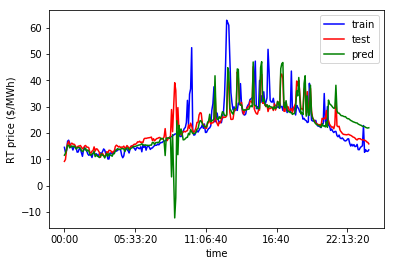

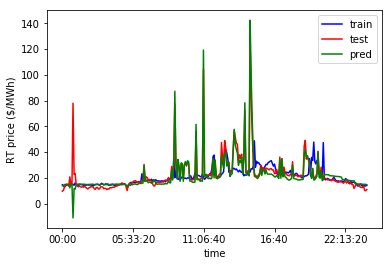

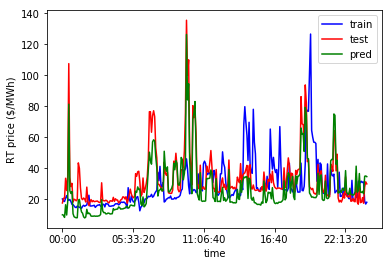

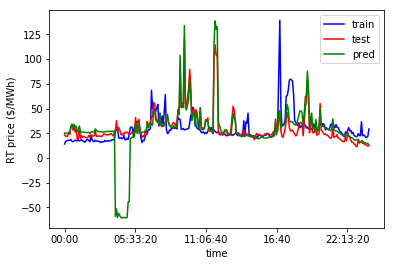

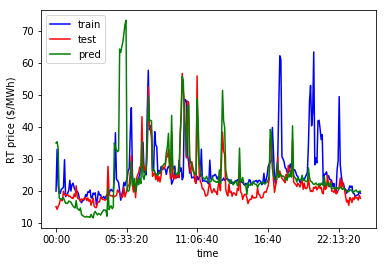

80.0%

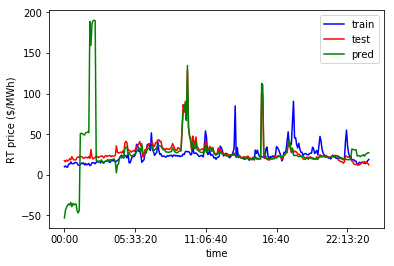

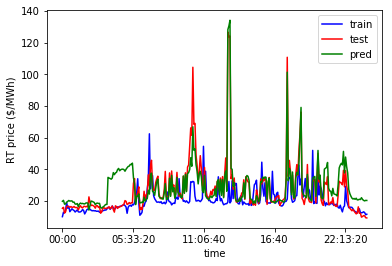

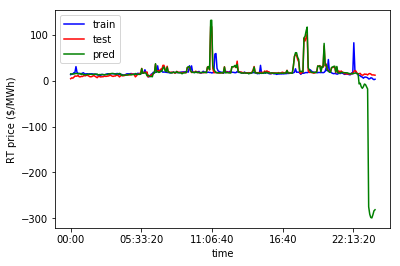

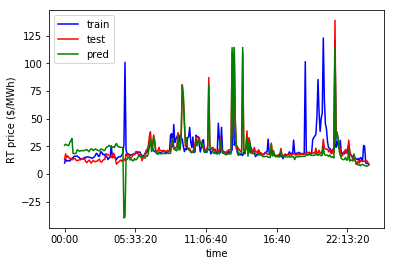

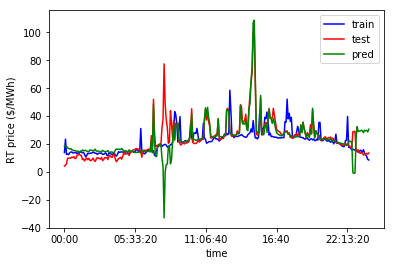

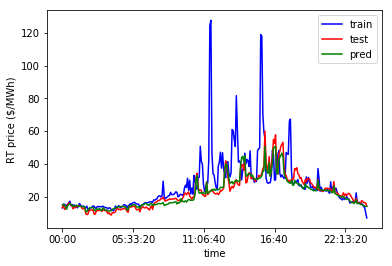

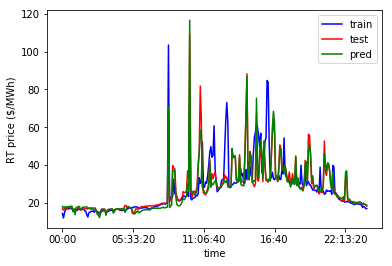

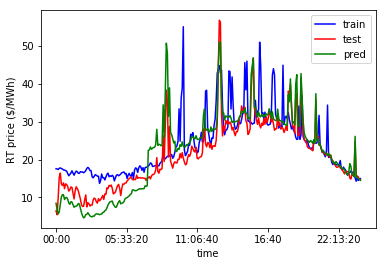

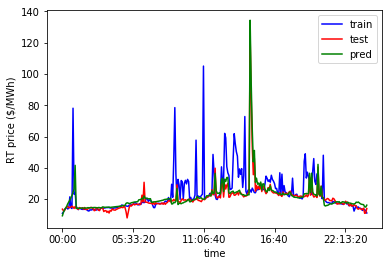

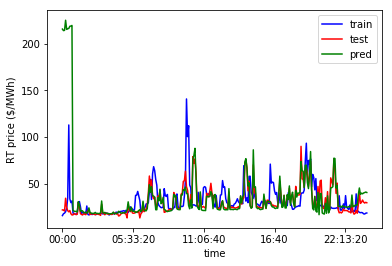

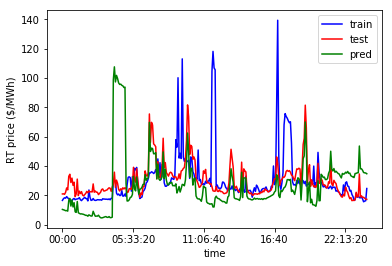

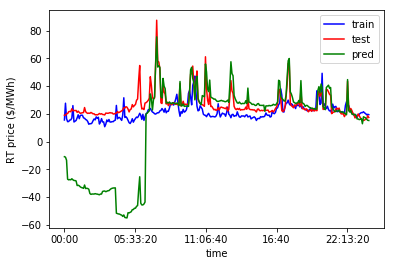

90.0%

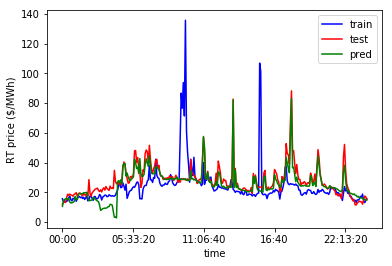

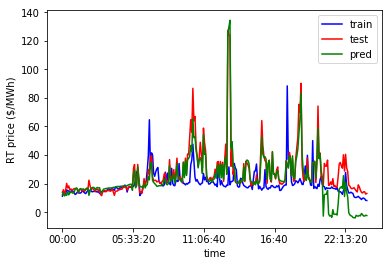

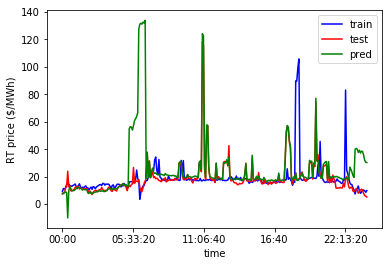

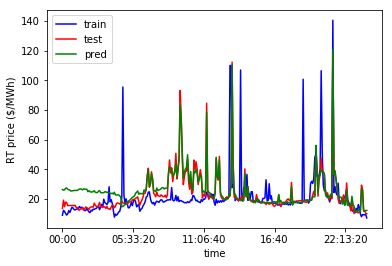

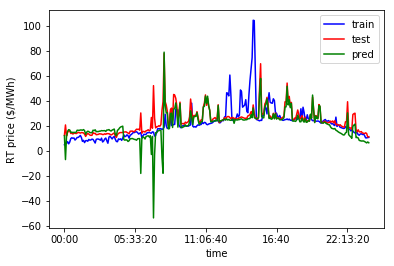

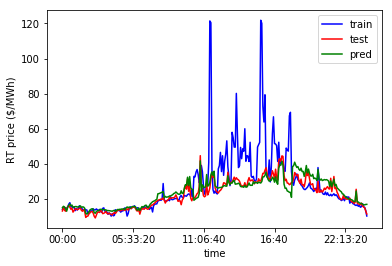

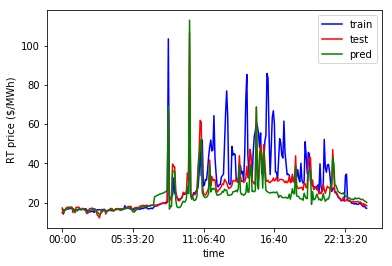

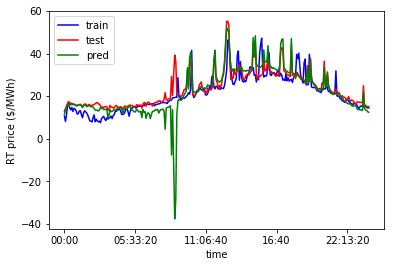

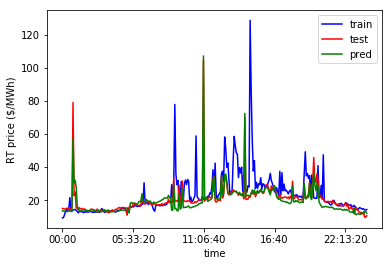

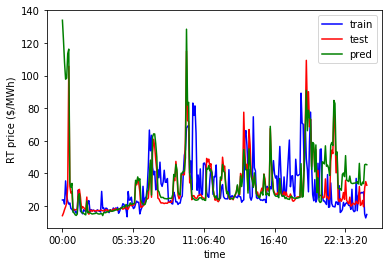

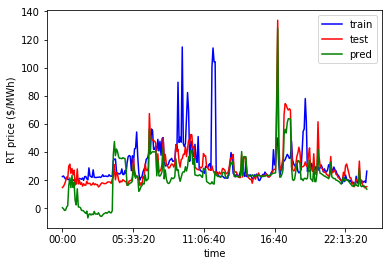

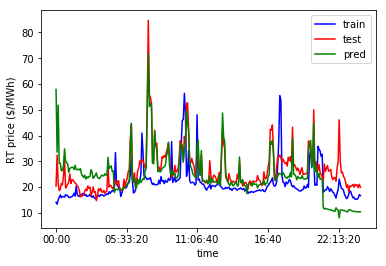

100.0%
MAPE ± std
6 predictors: 42.64873615813464 ± 60.56632759689415
5 predictors: 61.2077609469521 ± 62.80609361393562
# of errors: 0


In [53]:
# Testing different splitting

np.seterr(divide='print',invalid='print')

n = 10
PE_8_list = []
PE_4_list = []
errors = 0

df = DART2018

for i in range(n):
    for j in range(1,13):
        by_month = df[df['Month']==j]
        last_day = by_month.sort_values('Day')['Day'][-1]
        train_days = random.sample(range(1,last_day+1), 15)
        
        train = by_month.loc[by_month['Day'].isin(train_days)]
        train_data = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Previous_RT_2', 'Load_Diff']].mean()  
        train_data['RT_std'] = train.groupby('Local Time')['LMP_RT'].std()
        train_data['DA_std'] = train.groupby('Local Time')['LMP_DA'].std()        
        
        test = by_month.loc[~by_month['Day'].isin(train_days)]
        test_data = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind','Previous_RT_2', 'Load_Diff']].mean()  
        test_data['RT_std'] = test.groupby('Local Time')['LMP_RT'].std()
        test_data['DA_std'] = test.groupby('Local Time')['LMP_DA'].std() 
        test_data_copy = test_data.copy()
        
        test_data_copy['fitted RT (6)'] = np.zeros(test_data_copy.index.shape[0])
        test_data_copy['fitted RT (5)'] = np.zeros(test_data_copy.index.shape[0])
        branch_dfs = sklearn_clusters_2(train_data, 2, False)
        load_slopes = []
        for cluster in branch_dfs:
            try:
                result8 = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Previous_RT_2""", data=cluster).fit()
                result4 = smf.ols(formula="""LMP_RT ~ LMP_DA + Load + Wind + Previous_RT_2 + Load_Diff""", data=cluster).fit()
                for hour in cluster.index:
                    load_slopes.append(result8.params.loc['Load'])
                    test_data_copy['fitted RT (6)'].loc[hour] = (
                                                test_data_copy['Previous_RT_2'].loc[hour]*result8.params[6] +  
                                                test_data_copy['Wind'].loc[hour]*result8.params[5] + 
                                                test_data_copy['Load'].loc[hour]*result8.params[4] + 
                                                test_data_copy['DA_std'].loc[hour]*result8.params[3] + 
                                                test_data_copy['RT_std'].loc[hour]*result8.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result8.params[1] + 
                                                result8.params[0])
                    test_data_copy['fitted RT (5)'].loc[hour] = (
                                                test_data_copy['Load_Diff'].loc[hour]*result4.params[5] +  
                                                test_data_copy['Previous_RT_2'].loc[hour]*result4.params[4] +  
                                                test_data_copy['Wind'].loc[hour]*result4.params[3] + 
                                                test_data_copy['Load'].loc[hour]*result4.params[2] + 
                                                test_data_copy['LMP_DA'].loc[hour]*result4.params[1] + 
                                                result4.params[0])
            except:
                errors += 1
                print('\nerror occurred at i={} month={}'.format(i,j))
                continue
                
        plt.plot(train_data.index, train_data['LMP_RT'], 'blue', label='train')
        plt.plot(test_data.index, test_data['LMP_RT'], 'red', label='test')
        plt.plot(test_data.index, test_data_copy['fitted RT (6)'], 'green', label='pred')
        plt.ylabel('RT price ($/MWh)')
        plt.legend()
        plt.show()
            
        PE_8_list.append(pe(test_data_copy['fitted RT (6)'], test_data_copy['LMP_RT']).mean())
        PE_4_list.append(pe(test_data_copy['fitted RT (5)'], test_data_copy['LMP_RT']).mean())
        
    print(f'\r{100*(i+1)/n}%',end='')

PE_8_array = np.array(PE_8_list)
PE_4_array = np.array(PE_4_list)

print('\nMAPE \u00B1 std')
print('6 predictors: {} \u00B1 {}'.format(PE_8_array.mean(), PE_8_array.std()))
print('5 predictors: {} \u00B1 {}'.format(PE_4_array.mean(), PE_4_array.std()))
print('# of errors: {}'.format(errors))

In [52]:
# Splitting into two halves with random days can still yield quite differente samples

In [55]:
def crit_pts2(df):
    intervals = df.index.values.tolist()
    i = 0
    points = []
    for time in intervals:
        mean = df['LMP_RT'][0:i+1].mean()
        if df['LMP_RT'][i] > 2*mean:
            if (df['LMP_RT'][i] - mean) > df['LMP_RT'].mean()/3:
                if df['LMP_RT'][i] > 1.6*df['LMP_DA'][i]:
                    points.append(time)
        elif df['LMP_RT'][i] > 1.6*df['LMP_DA'][i]:
            points.append(time)
        i += 1
    x = np.array(points)
    
    i = 0
    LMP = []
    for time in df.index:
        if time in x:
            LMP.append(df['LMP_RT'][i])
        i += 1
    y = np.array(LMP)
    
    return [x,y]

C:\Users\felip\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


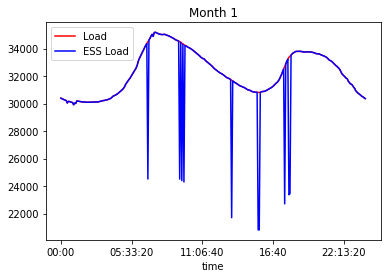

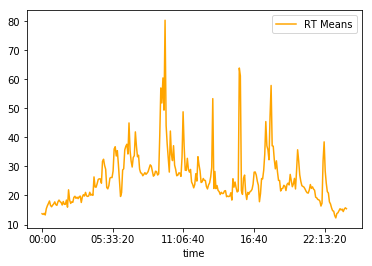

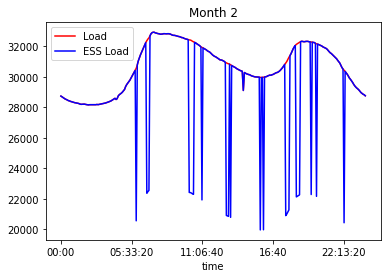

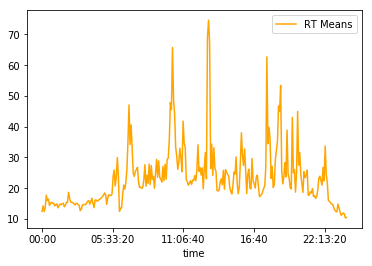

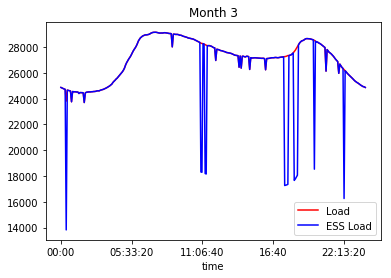

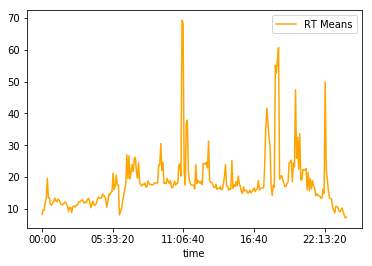

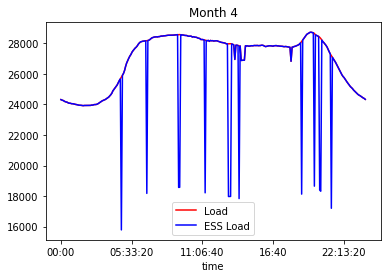

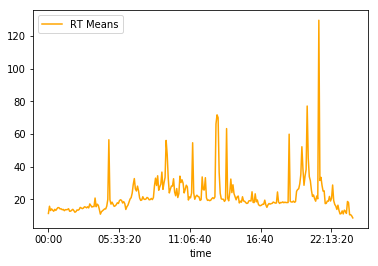

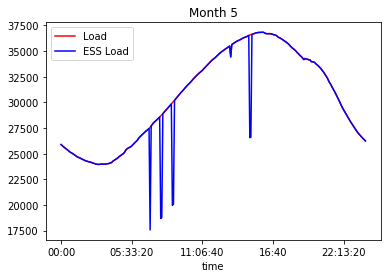

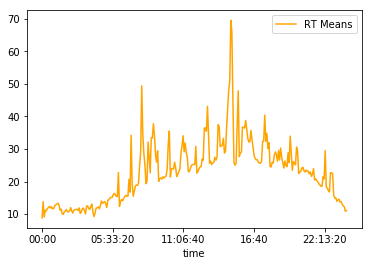

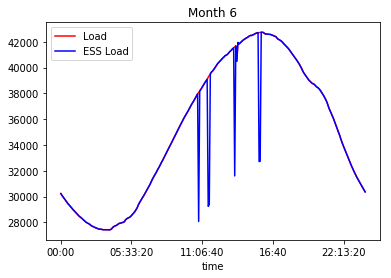

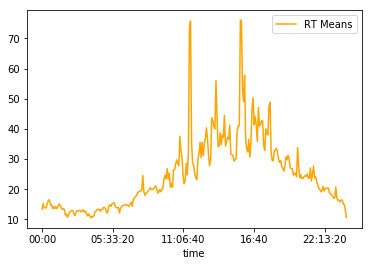

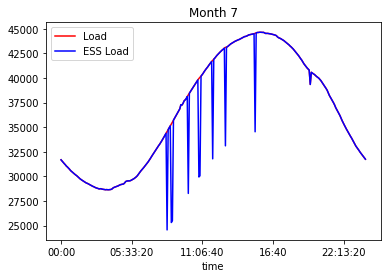

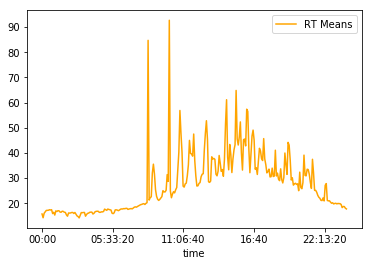

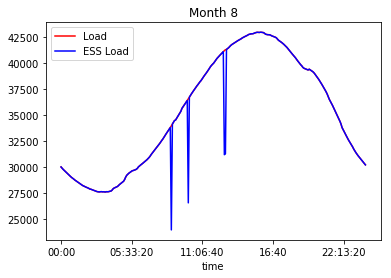

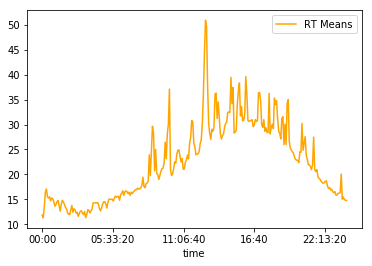

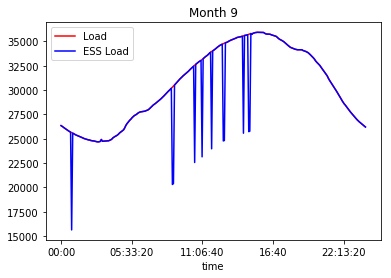

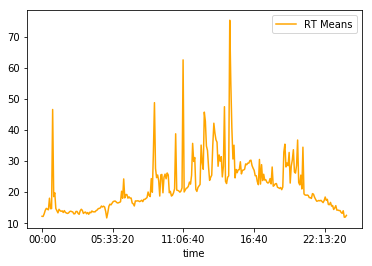

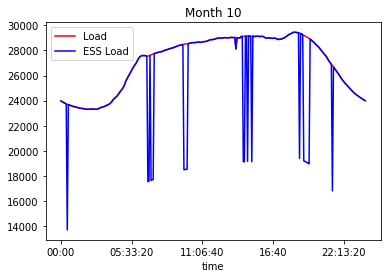

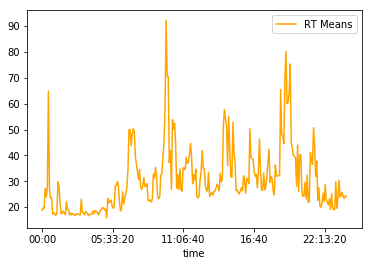

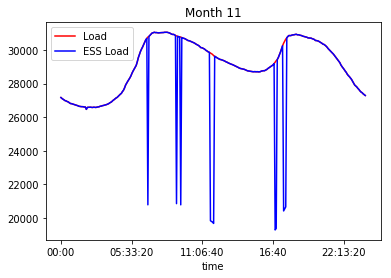

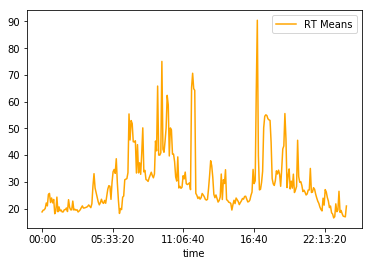

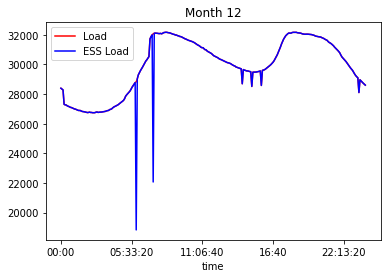

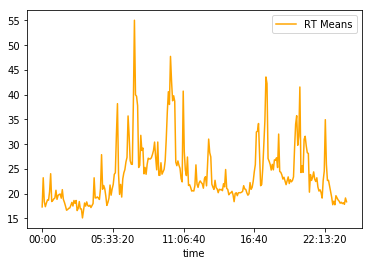

In [56]:
DART2018_ESS = DART2018
ESS_size = 10000
months = []
for month in range(1,13):
    by_month = DART2018[DART2018['Month']==month]
    by_month_ESS = DART2018_ESS[DART2018_ESS['Month']==month]

    study = by_month.groupby('Local Time')[['LMP_RT','LMP_DA','Load']].mean()
    
    critical = crit_pts2(study)[0]
    for t in critical:
        by_month_ESS.loc[by_month_ESS['Local Time'] == t, 'Load'] -= ESS_size
    
    study2 = by_month_ESS.groupby('Local Time')[['LMP_RT','LMP_DA','Load']].mean()

    months.append(by_month_ESS)
    
    plt.plot(study.index, study['Load'], 'red')
    plt.plot(study2.index, study2['Load'], 'blue', label='ESS Load')
    plt.title('Month {}'.format(month))
    plt.legend()
    plt.show()
    plt.plot(study.index, study['LMP_RT'], 'orange', label='RT Means')
    plt.legend()
    plt.show()

DART2018_ESS = pd.concat(months)

In [59]:
DART2018['Load_ESS'] = DART2018_ESS['Load']

-0.003993
-0.00416
0.003959
0.002103


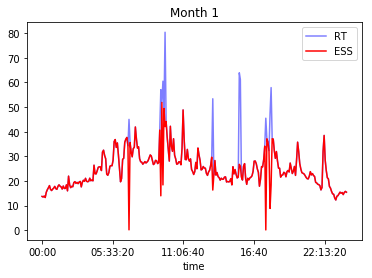

0.001421
0.006522
0.001683
0.003351


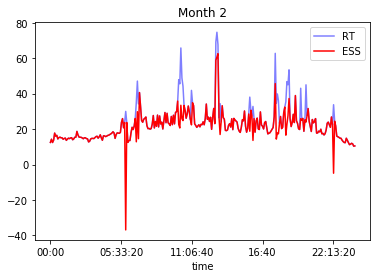

-0.000435
0.002972
0.001199
0.001369


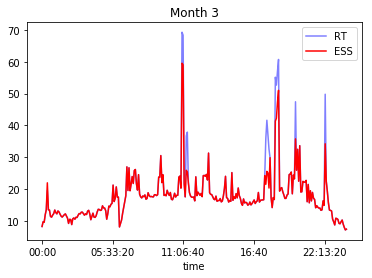

0.000192
0.001769
0.00126
0.0113


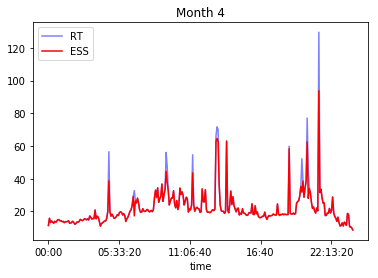

0.001062
0.000945
0.000719
0.002349


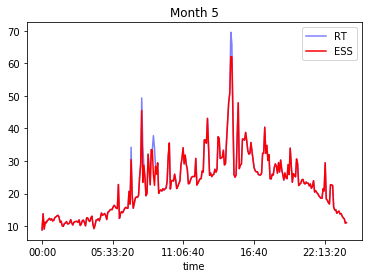

0.000931
0.001209
0.001211
0.0009


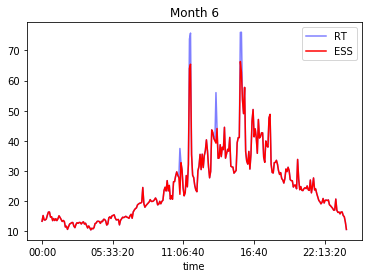

0.000361
0.000799
0.001468
0.000869


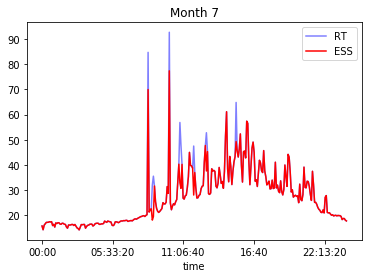

0.00026
0.001021
0.000979
0.001162


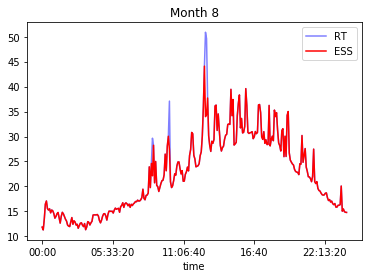

0.001694
0.000145
0.002093
0.0009


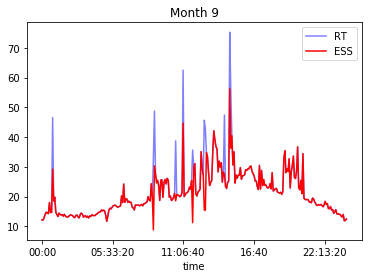

-0.030255
0.001528
0.003025
0.005619


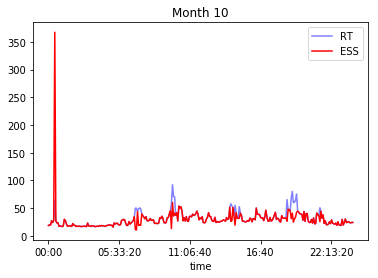

-0.002152
-0.003194
0.006309
0.006165


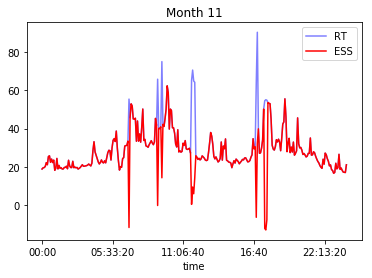

-0.000127
0.005141
0.001065
0.001819


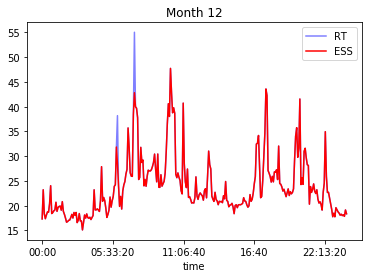

-42.901066

In [58]:
# Estimating price with multi-cluster, all-day MLR (previously-calculated slopes)

df = DART2018
df_ESS = DART2018_ESS
total_err = []
for j in range(1,13):
    by_month = df[df['Month']==j]
    by_month2 = df_ESS[df_ESS['Month']==j]

    study = by_month.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind', 'Previous_RT_2']].mean()
    study['RT_std'] = by_month.groupby('Local Time')['LMP_RT'].std()
    study['DA_std'] = by_month.groupby('Local Time')['LMP_DA'].std()        
    study['ESS RT'] = study['LMP_RT']
    
    study2 = by_month2.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind', 'Previous_RT_2']].mean()
    study2['RT_std'] = by_month2.groupby('Local Time')['LMP_RT'].std()
    study2['DA_std'] = by_month2.groupby('Local Time')['LMP_DA'].std()        
    study2['ESS RT'] = study2['LMP_RT']
    
    critical = crit_pts2(study)[0]
    critical_df = study.loc[critical]
    
    branch_dfs = sklearn_clusters_2(study, 2, False)
    for cluster in branch_dfs:            
        result = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Previous_RT_2""", data=study.loc[cluster.index]).fit()
        print(round(result.params.loc['Load'],6))
        for hour in cluster.index:
            if hour in critical.tolist():
                study2['ESS RT'].loc[hour] = (
                                        study2['Previous_RT_2'].loc[hour]*result.params.loc['Previous_RT_2'] +  
                                        study2['Wind'].loc[hour]*result.params.loc['Wind'] + 
                                        study2['Load'].loc[hour]*result.params.loc['Load'] + 
                                        study2['DA_std'].loc[hour]*result.params.loc['DA_std'] + 
                                        study2['RT_std'].loc[hour]*result.params.loc['RT_std'] + 
                                        study2['LMP_DA'].loc[hour]*result.params.loc['LMP_DA'] + 
                                        result.params.loc['Intercept'])
                p_err = 100*(study2['ESS RT'].loc[hour] - study2['LMP_RT'].loc[hour])/study2['LMP_RT'].loc[hour]
                total_err.append(p_err)
            
    plt.plot(study2.index, study2['LMP_RT'], 'blue', label='RT', alpha=0.5)
    plt.plot(study2.index, study2['ESS RT'], 'red', label='ESS')
    plt.title('Month {}'.format(j))
    plt.legend()
    plt.show()
    
round(np.array(total_err).mean(),6)

0.001153
0.001202
0.002746
0.001066


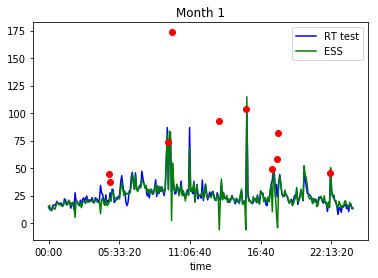

0.000615
-0.000864
0.001457
0.001015


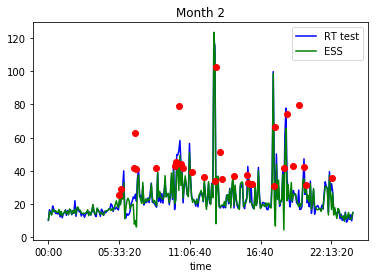

0.000233
0.008713
0.000871
-0.000424


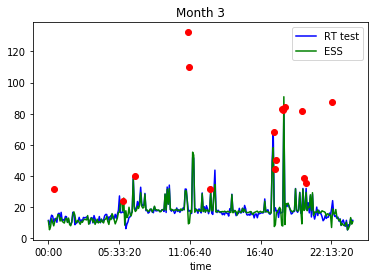

0.001355
0.000458
0.00014
0.006595


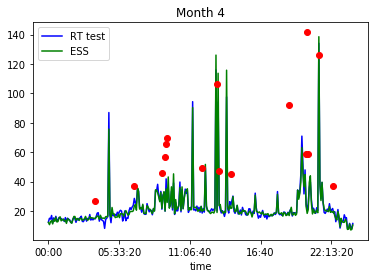

0.000797
0.001331
0.00088
2.8e-05


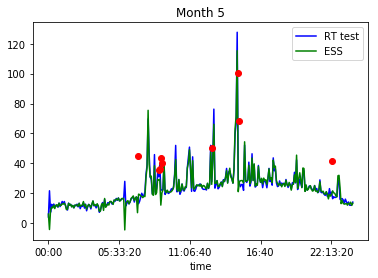

0.000214
0.001175
0.000813
0.001118


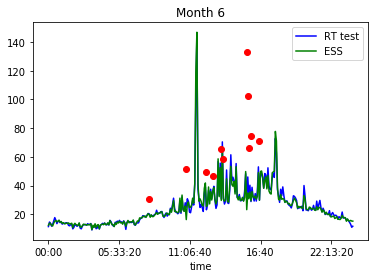

0.0005
0.000252
0.005467
0.000649


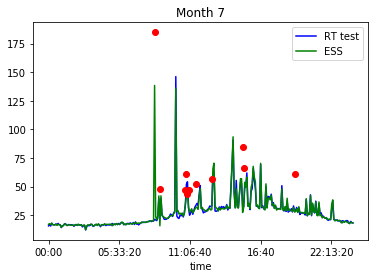

-0.000162
0.000983
0.000514
0.000954


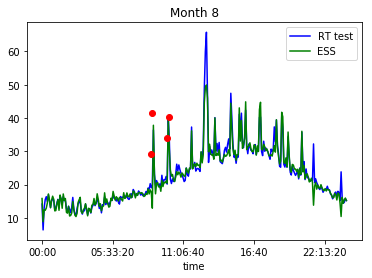

0.000434
0.000246
0.000546
0.001091


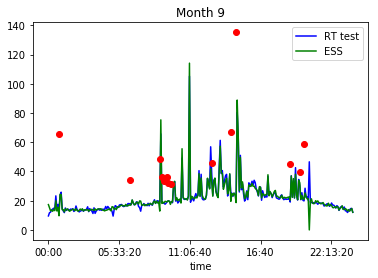

0.000555
0.005581
0.001697
0.001838


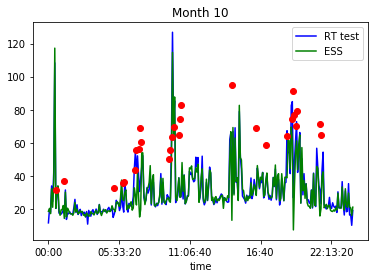

-0.000276
0.003019
0.002472
0.003905


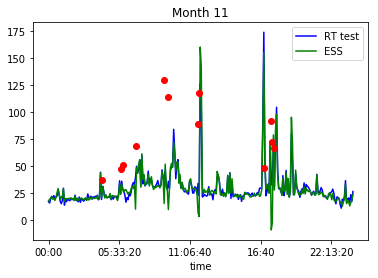

0.003183
0.000169
0.000297
0.001175


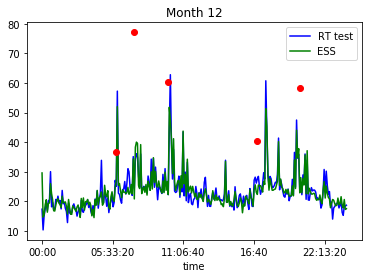

MAPE 7.408656912755084
peak % delta -18.704193645131152


In [60]:
# Estimating price with multi-cluster, all-day MLR + testing

df = DART2018
total_err = []
pe_list = []

for j in range(1,13):
    by_month = df[df['Month']==j]
    train, test = train_test_split(by_month, test_size=0.5)

    study = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind', 'Previous_RT_2']].mean()
    study['RT_std'] = train.groupby('Local Time')['LMP_RT'].std()
    study['DA_std'] = train.groupby('Local Time')['LMP_DA'].std()        
    
    study2 = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind', 'Previous_RT_2', 'Load_ESS']].mean()
    study2['RT_std'] = test.groupby('Local Time')['LMP_RT'].std()
    study2['DA_std'] = test.groupby('Local Time')['LMP_DA'].std()        
    study2['pred RT'] = np.zeros(study2.shape[0])
    study2['ESS RT'] = np.zeros(study2.shape[0])
    
    critical = crit_pts2(study)[0]
    critical_df = study.loc[critical]
    
    branch_dfs = sklearn_clusters_2(study, 2, False)
    
    for cluster in branch_dfs:            
        result = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Previous_RT_2""", data=cluster).fit()
        print(round(result.params.loc['Load'],6))
        for hour in cluster.index:
            study2['pred RT'].loc[hour] = (
                                        study2['Previous_RT_2'].loc[hour]*result.params[6] +  
                                        study2['Wind'].loc[hour]*result.params[5] + 
                                        study2['Load'].loc[hour]*result.params[4] + 
                                        study2['DA_std'].loc[hour]*result.params[3] + 
                                        study2['RT_std'].loc[hour]*result.params[2] + 
                                        study2['LMP_DA'].loc[hour]*result.params[1] + 
                                        result.params[0])
            if hour in critical.tolist():
                study2['ESS RT'].loc[hour] = (
                                        study2['Previous_RT_2'].loc[hour]*result.params[6] +  
                                        study2['Wind'].loc[hour]*result.params[5] + 
                                        study2['Load_ESS'].loc[hour]*result.params[4] + 
                                        study2['DA_std'].loc[hour]*result.params[3] + 
                                        study2['RT_std'].loc[hour]*result.params[2] + 
                                        study2['LMP_DA'].loc[hour]*result.params[1] + 
                                        result.params[0])
                p_err = 100*(study2['ESS RT'].loc[hour] - study2['LMP_RT'].loc[hour])/study2['LMP_RT'].loc[hour]
                total_err.append(p_err)
            else:
                study2['ESS RT'].loc[hour] = study2['pred RT'].loc[hour]
                
    pe_list.append(pe(study2['pred RT'], study2['LMP_RT']).mean())

    plt.plot(study2.index, study2['LMP_RT'], 'blue', label='RT test')
    plt.plot(study2.index, study2['ESS RT'], 'green', label='ESS')
    #plt.plot(study2.index, study2['pred RT'], 'orange', label='RT prediction')
    plt.plot(critical, crit_pts2(study)[1], 'ro')
    plt.title('Month {}'.format(j))
    plt.legend()
    plt.show()

print('MAPE {}'.format(np.array(pe_list).mean()))
print('peak % delta {}'.format(np.array(total_err).mean()))

-0.000401
-0.000323
0.003045
0.001767


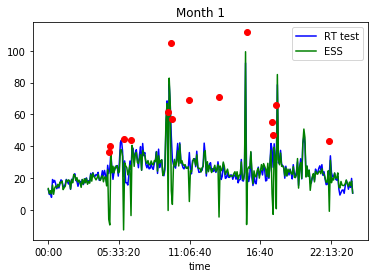

0.000709
0.001982
0.001093
0.001614


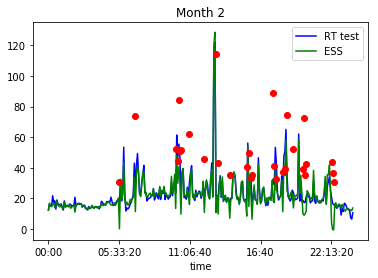

3e-05
0.000728
0.001013
-0.000123


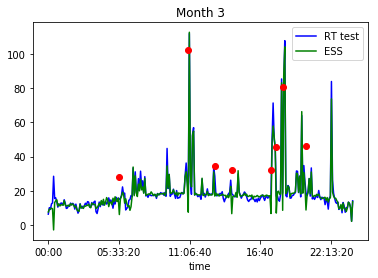

0.001828
0.001138
0.039129
0.001499


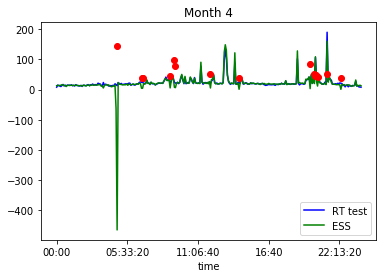

-0.000143
0.001031
0.000776
0.000928


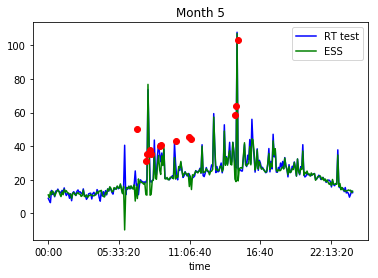

0.000389
0.001234
0.000666
0.001023


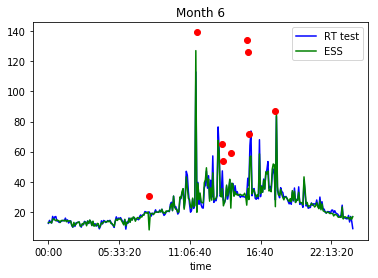

0.000297
-8.7e-05
0.001392
0.000663


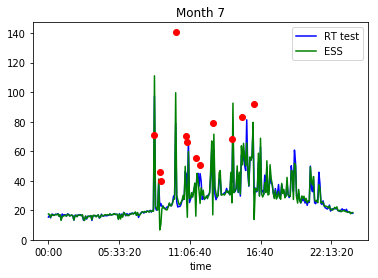

0.000113
0.000272
0.000593
0.001124


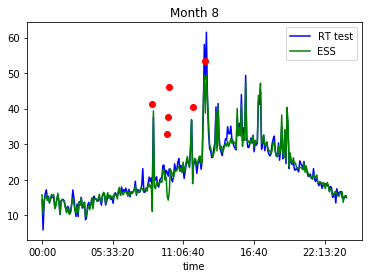

0.00839
0.000583
0.000921
0.00062


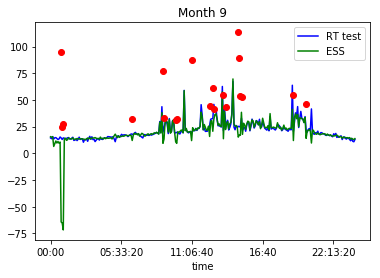

-0.00285
0.000711
0.000839
0.003067


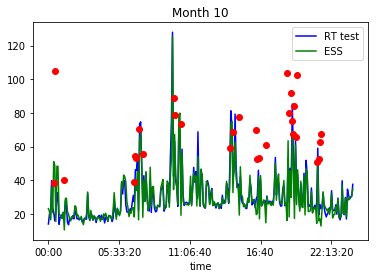

0.000868
-0.000834
0.00407
0.001597


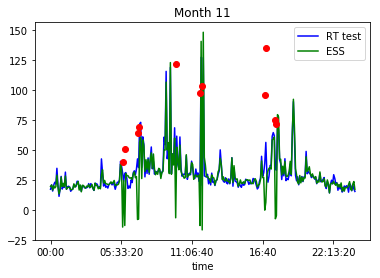

-9.7e-05
0.000414
-9e-06
0.001517


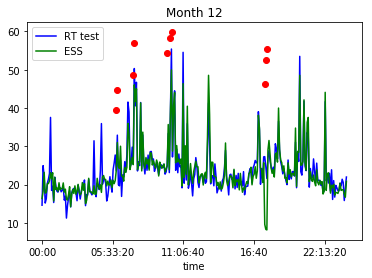

MAPE 7.785256662451758
peak % delta -77.43088641655902


In [61]:
# Estimating price with multi-cluster, all-day MLR + testing -- dif load_ess

df = DART2018
total_err = []
pe_list = []

for j in range(1,13):
    by_month = df[df['Month']==j]
    train, test = train_test_split(by_month, test_size=0.5)

    study = train.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind', 'Previous_RT_2']].mean()
    study['RT_std'] = train.groupby('Local Time')['LMP_RT'].std()
    study['DA_std'] = train.groupby('Local Time')['LMP_DA'].std()        
    
    study2 = test.groupby('Local Time')[['LMP_RT','LMP_DA','Load','Wind', 'Previous_RT_2', 'Load_ESS']].mean()
    study2['RT_std'] = test.groupby('Local Time')['LMP_RT'].std()
    study2['DA_std'] = test.groupby('Local Time')['LMP_DA'].std()        
    study2['pred RT'] = np.zeros(study2.shape[0])
    study2['ESS RT'] = np.zeros(study2.shape[0])
    
    critical = crit_pts2(study)[0]
    critical_df = study.loc[critical]
    
    branch_dfs = sklearn_clusters_2(study, 2, False)
    
    for cluster in branch_dfs:            
        result = smf.ols(formula="""LMP_RT ~ LMP_DA + RT_std + DA_std + Load + Wind + Previous_RT_2""", data=cluster).fit()
        print(round(result.params.loc['Load'],6))
        for hour in cluster.index:
            study2['pred RT'].loc[hour] = (
                                        study2['Previous_RT_2'].loc[hour]*result.params[6] +  
                                        study2['Wind'].loc[hour]*result.params[5] + 
                                        study2['Load'].loc[hour]*result.params[4] + 
                                        study2['DA_std'].loc[hour]*result.params[3] + 
                                        study2['RT_std'].loc[hour]*result.params[2] + 
                                        study2['LMP_DA'].loc[hour]*result.params[1] + 
                                        result.params[0])
            if hour in critical.tolist():
                study2['ESS RT'].loc[hour] = (
                                        study2['Previous_RT_2'].loc[hour]*result.params[6] +  
                                        study2['Wind'].loc[hour]*result.params[5] + 
                                        (study2['Load'].loc[hour] - 10000)*result.params[4] + 
                                        study2['DA_std'].loc[hour]*result.params[3] + 
                                        study2['RT_std'].loc[hour]*result.params[2] + 
                                        study2['LMP_DA'].loc[hour]*result.params[1] + 
                                        result.params[0])
                p_err = 100*(study2['ESS RT'].loc[hour] - study2['LMP_RT'].loc[hour])/study2['LMP_RT'].loc[hour]
                total_err.append(p_err)
            else:
                study2['ESS RT'].loc[hour] = study2['pred RT'].loc[hour]
                
    pe_list.append(pe(study2['pred RT'], study2['LMP_RT']).mean())

    plt.plot(study2.index, study2['LMP_RT'], 'blue', label='RT test')
    plt.plot(study2.index, study2['ESS RT'], 'green', label='ESS')
    #plt.plot(study2.index, study2['pred RT'], 'orange', label='RT prediction')
    plt.plot(critical, crit_pts2(study)[1], 'ro')
    plt.title('Month {}'.format(j))
    plt.legend()
    plt.show()

print('MAPE {}'.format(np.array(pe_list).mean()))
print('peak % delta {}'.format(np.array(total_err).mean()))